<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_Iron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process**

# **(Iron Concentrate)**

## **1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

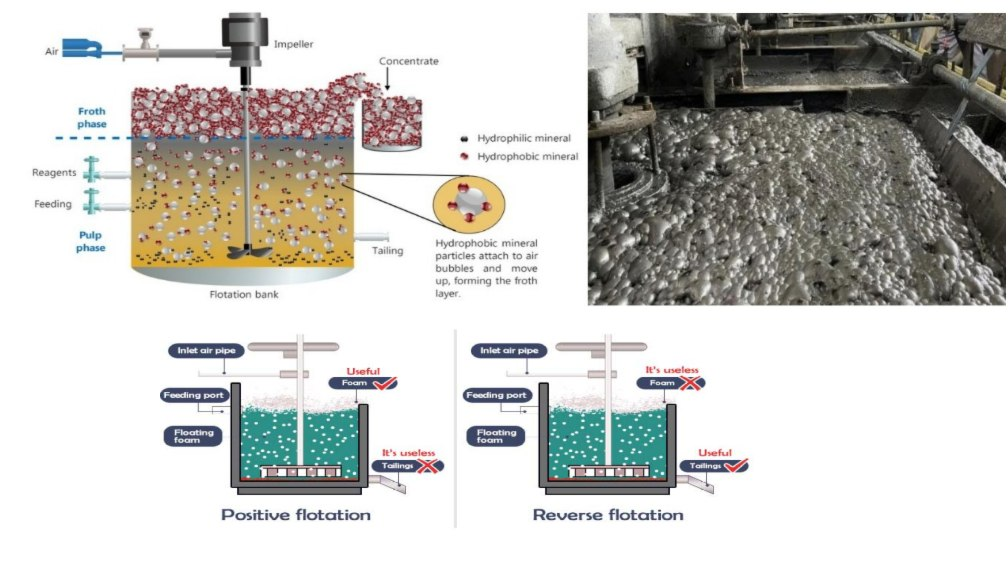

Flotation concentrate is periodically sampled to determine its purity (percentage of gangue). Higher purity in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict iron and gangue (silica) concentrate in the flotation output. The prediction will help process engineers assess the purity and take corrective actions in advance.

Source of dataset: https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time. (There is imbalance in measurement of variables)
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

### **2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017).
- Measurements are taken every 5-6 hours for the first 2 columns (input - raw material).
- Measurements are taken every 1 hour for the last 2 columns (output - processed material).
- Some columns were sampled every 20 second.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant.
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process.
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality).
- The last two columns are the final iron ore pulp quality measurement from the lab.

### **2.3. Aim of the Project**

- To predict the percentage of output (iron and silica) concentrate in the mineral processing (reverse cationic flotation) plant

##**3. Data Collection**

###**3.1. Import Libraries**

In [2]:
import math
import random
import time
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, pearsonr
from scipy.cluster import hierarchy as hc
sns.set_theme(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

###**3.2. Import Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv')

Mounted at /content/drive/
/content/drive/My Drive/Flotation


##**4. Data Preprocessing**

###**4.1. Dataset Information**

In [4]:
flotation.sample(5).T

389769               602323  \
date                          2017-06-21 12:00:00  2017-08-09 17:00:00   
% Iron Feed                                 52,67                48,81   
% Silica Feed                               17,88                25,31   
Starch Flow                        697,1829305741              3282,85   
Amina Flow                         247,9881227545               475,23   
Ore Pulp Flow                      397,1400708117              379,675   
Ore Pulp pH                               9,29712              9,67486   
Ore Pulp Density                     1,5199821638              1,67973   
Flotation Column 01 Air Flow       177,4447050562              297,707   
Flotation Column 02 Air Flow       185,3920862689              296,541   
Flotation Column 03 Air Flow        202,107589504              301,801   
Flotation Column 04 Air Flow       299,0401330472        304,443157651   
Flotation Column 05 Air Flow       297,0658667446       298,0286061645   
Flotation Column 06 Air Flow              201,919              286,213   
Flotation Column 07 Air Flow               203,35              300,043   
Flotation Column 01 Level                 480,013       302,0941428571   
Flotation Column 02 Level          685,4569194805              520,129   
Flotation Column 03 Level           867,651252894              599,639   
Flotation Column 04 Level          610,8629655623              317,179   
Flotation Column 05 Level          640,8498573906              360,851   
Flotation Column 06 Level          666,0761126057              372,427   
Flotation Column 07 Level          536,7927119696              393,379   
% Iron Concentrate                          64,99                65,09   
% Silica Concentrate                          2,4                 2,41   

                                           511319               63654   \
date                          2017-07-19 15:00:00  2017-04-07 00:00:00   
% Iron Feed                                 47,05                57,34   
% Silica Feed                               28,14                13,06   
Starch Flow                               4723,39               2197,9   
Amina Flow                                403,484              521,292   
Ore Pulp Flow                             401,792              398,765   
Ore Pulp pH                                10,057              9,89621   
Ore Pulp Density                          1,71409              1,76999   
Flotation Column 01 Air Flow               299,73              250,104   
Flotation Column 02 Air Flow              297,245              253,185   
Flotation Column 03 Air Flow               301,95              249,661   
Flotation Column 04 Air Flow              301,003              295,096   
Flotation Column 05 Air Flow              298,646                306,4   
Flotation Column 06 Air Flow              300,093              248,885   
Flotation Column 07 Air Flow              300,737              249,558   
Flotation Column 01 Level                 550,537              798,502   
Flotation Column 02 Level                  433,32              794,849   
Flotation Column 03 Level                 400,663              801,738   
Flotation Column 04 Level                  317,66              406,031   
Flotation Column 05 Level                  285,95              405,422   
Flotation Column 06 Level                 340,847              444,456   
Flotation Column 07 Level                 440,513              401,116   
% Iron Concentrate                           66,2                 65,8   
% Silica Concentrate                         1,33                 2,12   

                                           168380  
date                          2017-05-01 06:00:00  
% Iron Feed                                 54,44  
% Silica Feed                               18,65  
Starch Flow                               2328,13  
Amina Flow                                529,126  
Ore Pulp Flow                

In [5]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date                          737453 non-null  object
 1   % Iron Feed                   737453 non-null  object
 2   % Silica Feed                 737453 non-null  object
 3   Starch Flow                   737453 non-null  object
 4   Amina Flow                    737453 non-null  object
 5   Ore Pulp Flow                 737453 non-null  object
 6   Ore Pulp pH                   737453 non-null  object
 7   Ore Pulp Density              737453 non-null  object
 8   Flotation Column 01 Air Flow  737453 non-null  object
 9   Flotation Column 02 Air Flow  737453 non-null  object
 10  Flotation Column 03 Air Flow  737453 non-null  object
 11  Flotation Column 04 Air Flow  737453 non-null  object
 12  Flotation Column 05 Air Flow  737453 non-null  object
 13 

In [6]:
flotation.describe().T

count  unique                  top    freq
date                          737453    4097  2017-06-16 15:00:00     180
% Iron Feed                   737453     278                64,03  142560
% Silica Feed                 737453     293                 6,26  142560
Starch Flow                   737453  409317               2562,5     690
Amina Flow                    737453  319416              534,668     959
Ore Pulp Flow                 737453  180189              402,246    1735
Ore Pulp pH                   737453  131143              10,0591    1509
Ore Pulp Density              737453  105805                 1,75    3214
Flotation Column 01 Air Flow  737453   43675              299,927   13683
Flotation Column 02 Air Flow  737453   80442              255,322    1487
Flotation Column 03 Air Flow  737453   40630              298,828    6012
Flotation Column 04 Air Flow  737453  196006              295,096   82829
Flotation Column 05 Air Flow  737453  194711                306,4   82832
Flotation Column 06 Air Flow  737453   90548              299,927   13766
Flotation Column 07 Air Flow  737453   86819              299,487    3405
Flotation Column 01 Level     737453  299573              452,441    1013
Flotation Column 02 Level     737453  331189              608,887     817
Flotation Column 03 Level     737453  322315               601,06     989
Flotation Column 04 Level     737453  309264              491,406     733
Flotation Column 05 Level     737453  276051              513,879     709
Flotation Column 06 Level     737453  301502               474,37     746
Flotation Column 07 Level     737453  295667              479,478     905
% Iron Concentrate            737453   38696                65,44   16920
% Silica Concentrate          737453   55569                 2,08   17100

###**4.2.  Apply Corrections on Dataset**

**There are a lot of unreasonable values in some variables:**

- Ore Pulp Flow (plant input ore slury) is aproximately 400 t/h.
- When we look the Ore Pulp Flow column most of the values with different decimal figures ("394,57" - "568848") in tons/hour
- Starch Flow and Amina Flow columns have different unbalanced values ("3019,53" - "367383" - "3121" - "1645,3466666667") in m³/hour
- Ore Pulp Density has not any problem ("1,74" - "1,78055")
- Ore Pulp pH must  be in range 0-14. But some values in thousands ("10068" - "9,95376", "9602")
- Flotation Column Air Flow values ("249.214" - "300.2481959288") in Nm³/h
- Flotation Column Level values ("453.942" - "868.6261818182") in mm
- There is no problem in % Iron Concentrate, % Silica Concentrate columns




**Corrections**

In [7]:
columns_to_convert = ['% Iron Feed', '% Silica Feed', '% Iron Concentrate',
                      '% Silica Concentrate', 'Ore Pulp Density']

for column in columns_to_convert:
    flotation[column] = flotation[column].str.replace(',', '.').astype(float).round(2)

In [8]:
columns_to_update = ["Starch Flow", "Amina Flow", "Ore Pulp Flow"]

flotation[columns_to_update] = (flotation[columns_to_update].replace(",", "", regex=True)
                               .apply(lambda x: x.str[:3] + "." + x.str[3:])
                               .astype(float).round(3))

In [9]:

flotation["Ore Pulp pH"] = (flotation["Ore Pulp pH"].str.replace(",", ".", regex=True)
                           .apply(lambda x: float(x[:2] + x[2:].replace(".", ""))
                           if "," in x else float(x)).round(2))

In [10]:
columns_to_update = ["Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                     "Flotation Column 04 Air Flow", "Flotation Column 05 Air Flow", "Flotation Column 06 Air Flow",
                     "Flotation Column 07 Air Flow"]

for column in columns_to_update:
    flotation[column] = flotation[column].str.replace(",", "")
    flotation[column] = flotation[column].apply(lambda x: "{:d}.{:s}".format(int(x[:3]), x[3:]) if len(x) > 3 else np.nan)
    flotation[column] = flotation[column].astype('float64').round(3)

In [11]:
columns_to_update = ["Flotation Column 01 Level", "Flotation Column 02 Level", "Flotation Column 03 Level",
                     "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level",
                     "Flotation Column 07 Level"]

for column in columns_to_update:
    flotation[column] = flotation[column].str.replace(",", "")
    flotation[column] = flotation[column].apply(lambda x: "{:d}.{:s}".format(int(x[:3]), x[3:]) if len(x) > 3 else np.nan)
    flotation[column] = flotation[column].astype('float64').round(3)

In [12]:
flotation['Airflow'] = flotation[["Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow",
                                  "Flotation Column 03 Air Flow", "Flotation Column 04 Air Flow",
                                  "Flotation Column 05 Air Flow", "Flotation Column 06 Air Flow",
                                  "Flotation Column 07 Air Flow"]].mean(axis=1).round(3)

flotation.drop(["Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow",
                "Flotation Column 03 Air Flow", "Flotation Column 04 Air Flow",
                "Flotation Column 05 Air Flow", "Flotation Column 06 Air Flow",
                "Flotation Column 07 Air Flow"], axis=1, inplace=True)

In [13]:
flotation['Level'] = flotation[["Flotation Column 01 Level", "Flotation Column 02 Level",
                                "Flotation Column 03 Level", "Flotation Column 04 Level",
                                "Flotation Column 05 Level", "Flotation Column 06 Level",
                                "Flotation Column 07 Level"]].mean(axis=1).round(3)

flotation.drop(["Flotation Column 01 Level", "Flotation Column 02 Level",
                "Flotation Column 03 Level", "Flotation Column 04 Level",
                "Flotation Column 05 Level", "Flotation Column 06 Level",
                "Flotation Column 07 Level"], axis=1, inplace=True)

In [14]:
flotation.sample(5).T

169087               516107  \
date                  2017-05-01 10:00:00  2017-07-20 18:00:00   
% Iron Feed                         51.71                55.73   
% Silica Feed                       20.44                14.36   
Starch Flow                       225.325              622.038   
Amina Flow                        362.234              525.353   
Ore Pulp Flow                      402.42              395.317   
Ore Pulp pH                           9.8                10.52   
Ore Pulp Density                      1.6                 1.65   
% Iron Concentrate                  65.79                66.13   
% Silica Concentrate                 2.38                 1.32   
Airflow                           300.546              299.175   
Level                             524.837              692.952   

                                   709642               635256  \
date                  2017-09-03 13:00:00  2017-08-17 08:00:00   
% Iron Feed                          52.9                55.53   
% Silica Feed                       18.04                13.32   
Starch Flow                       145.034                176.5   
Amina Flow                        502.778              301.567   
Ore Pulp Flow                     391.064              385.428   
Ore Pulp pH                          9.67                 9.88   
Ore Pulp Density                     1.63                 1.66   
% Iron Concentrate                  63.16                65.26   
% Silica Concentrate                 2.58                 1.19   
Airflow                           302.871              300.871   
Level                             434.811              633.949   

                                   451347  
date                  2017-07-05 18:00:00  
% Iron Feed                         53.63  
% Silica Feed                       15.74  
Starch Flow                       294.184  
Amina Flow                        561.523  
Ore Pulp Flow                     404.004  
Ore Pulp pH                          9.96  
Ore Pulp Density                     1.71  
% Iron Concentrate                  65.71  
% Silica Concentrate                 1.86  
Airflow                           288.532  
Level                             420.439

###**4.3. Check Missing & Duplicated Values**

In [15]:
missing_values = flotation.isnull().sum()
print(missing_values)

date                    0
% Iron Feed             0
% Silica Feed           0
Starch Flow             0
Amina Flow              0
Ore Pulp Flow           0
Ore Pulp pH             0
Ore Pulp Density        0
% Iron Concentrate      0
% Silica Concentrate    0
Airflow                 0
Level                   0
dtype: int64


- There are no missing values in the the dataframe

In [16]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

date                    1449
% Iron Feed             1449
% Silica Feed           1449
Starch Flow             1449
Amina Flow              1449
Ore Pulp Flow           1449
Ore Pulp pH             1449
Ore Pulp Density        1449
% Iron Concentrate      1449
% Silica Concentrate    1449
Airflow                 1449
Level                   1449
dtype: int64

In [17]:
# Count the number of duplicate rows
num_duplicates = flotation.duplicated().sum()
# Drop the duplicate rows from the DataFrame
flotation.drop_duplicates(inplace=True)
# Verify that duplicate rows have been eliminated
print("Number of duplicate rows:", num_duplicates)
print("Number of rows after removing duplicates:", len(flotation))

Number of duplicate rows: 1449
Number of rows after removing duplicates: 736004


In [18]:
flotation.columns

Index(['date', '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       '% Iron Concentrate', '% Silica Concentrate', 'Airflow', 'Level'],
      dtype='object')

### **4.4. Rename Columns**

In [19]:
# Rename column names
old_columns = ['date', '% Iron Feed', '% Silica Feed',
               'Starch Flow', 'Amina Flow', 'Ore Pulp Flow',
               'Ore Pulp pH', 'Ore Pulp Density', '% Iron Concentrate',
               '% Silica Concentrate', 'Airflow', 'Level']

new_columns = ["date","iron_feed", "silica_feed",
               "starch_flow", "amina_flow", "pulp_flow",
               "pulp_pH", "pulp_density", "iron_conc",
               "silica_conc", "airflow", "level"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))
flotation.columns

Index(['date', 'iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
       'pulp_flow', 'pulp_pH', 'pulp_density', 'iron_conc', 'silica_conc',
       'airflow', 'level'],
      dtype='object')

In [20]:
flotation.sample(5).T

704456               305284               144321  \
date          2017-09-02 08:00:00  2017-06-01 23:00:00  2017-04-25 16:00:00   
iron_feed                   55.39                64.03                54.52   
silica_feed                  17.5                 6.26                20.56   
starch_flow               151.502              429.598              578.958   
amina_flow                565.753              507.893              292.242   
pulp_flow                 380.859              397.123              413.767   
pulp_pH                      9.48                 9.97                 9.92   
pulp_density                 1.72                 1.72                 1.52   
iron_conc                   64.73                 63.0                66.47   
silica_conc                  2.94                 1.81                 1.09   
airflow                   314.037              293.225              300.908   
level                     438.088              541.844              658.195   

                           346323               82630   
date          2017-06-11 11:00:00  2017-04-11 10:00:00  
iron_feed                   64.03                56.57  
silica_feed                  6.26                13.47  
starch_flow               393.299              404.379  
amina_flow                584.536              273.385  
pulp_flow                  406.35              381.346  
pulp_pH                       9.7                 9.21  
pulp_density                  1.7                 1.53  
iron_conc                   66.42                65.28  
silica_conc                  1.48                 1.68  
airflow                   299.663              230.514  
level                     515.105              704.991

In [21]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736004 entries, 0 to 737452
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          736004 non-null  object 
 1   iron_feed     736004 non-null  float64
 2   silica_feed   736004 non-null  float64
 3   starch_flow   736004 non-null  float64
 4   amina_flow    736004 non-null  float64
 5   pulp_flow     736004 non-null  float64
 6   pulp_pH       736004 non-null  float64
 7   pulp_density  736004 non-null  float64
 8   iron_conc     736004 non-null  float64
 9   silica_conc   736004 non-null  float64
 10  airflow       736004 non-null  float64
 11  level         736004 non-null  float64
dtypes: float64(11), object(1)
memory usage: 73.0+ MB


### **4.5. Grouping Rows With Hourly Frequency**

The importance of considering plant data as a holistic entity was emphasized in order to gain a comprehensive understanding. To achieve this, a loop-based analysis methodology was employed. Each row of data was treated as an individual iteration, representing a complete cycle of feeding 100 tons of ore to the plant, enriching it, and concluding the process. For the purpose of this study, each cycle was set at a duration of one hour. Consequently, a photograph of the plant was captured at hourly intervals and subjected to analysis. It is worth noting that if a more frequent and regular data collection scheme were in place, such as cycles occurring every minute, it would yield a larger dataset suitable for machine learning applications.

In [22]:
flotation['date'] = pd.to_datetime(flotation['date'])
#grouping the data according to the hours and get their average values.
flotation_grouped = flotation.groupby(pd.Grouper(key='date',freq='H')).mean()
# cycle_data.insert(0,'Date',cycle_data.index)
flotation_grouped.reset_index(inplace = True)

#some rows have 'null' values because of timing. We need to drop them
print('Shape of Grouped Flotation Dataset = ', flotation_grouped.shape)
flotation = flotation_grouped.dropna()
print('Shape of Grouped Flotation Dataset after drop null values = ', flotation.shape);

Shape of Grouped Flotation Dataset =  (4415, 12)
Shape of Grouped Flotation Dataset after drop null values =  (4097, 12)


The grouping process has a number of advantages and disadvantages.

**Advantages:**
Each analysis will be able to do each data cycle on an hourly frequency.
Date column can be dropped. The number of columns fell to 23.
The number of rows fell to 4097 from 737453. Every rows means calculations on computer.

**Disadvantage:** The number of rows fell to 4097 from 737453. The more rows we have for machine learning, the better results we get. This large data loss will adversely affect our estimation results.

**Dropping unnecessary date column**

In [23]:
flotation_copy = flotation.copy()
flotation_copy.drop(['date'], axis=1, inplace=True)

In [24]:
missing_values = flotation.isnull().sum()
print(missing_values)

date            0
iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
iron_conc       0
silica_conc     0
airflow         0
level           0
dtype: int64


In [25]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

date            0
iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
iron_conc       0
silica_conc     0
airflow         0
level           0
dtype: int64

### **4.6. Reorder the Columns**

In [26]:
column_order = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
                'pulp_density', 'airflow', 'level', 'iron_conc', 'silica_conc']

flotation = flotation.reindex(columns=column_order)
flotation.columns

Index(['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'airflow', 'level', 'iron_conc',
       'silica_conc'],
      dtype='object')

##**5. Exploratory Data Analysis**

###**5.1. Corellation Between the Variables**

In [27]:
flotation.describe().T

count        mean        std         min         25%  \
iron_feed     4097.0   56.294730   5.158347   42.740000   52.670000   
silica_feed   4097.0   14.651733   6.808236    1.310000    8.940000   
starch_flow   4097.0  338.145985  92.676974  102.567372  283.586733   
amina_flow    4097.0  488.160974  83.694176  242.927478  436.037967   
pulp_flow     4097.0  397.576497   8.370236  376.837611  398.848778   
pulp_pH       4097.0    9.767644   0.378189    8.750000    9.540889   
pulp_density  4097.0    1.680348   0.063875    1.520000    1.651389   
airflow       4097.0  288.656648  18.520292  221.601528  278.442433   
level         4097.0  467.251792  74.329034  340.585206  399.868750   
iron_conc     4097.0   65.050082   1.118100   62.050000   64.370000   
silica_conc   4097.0    2.326751   1.124779    0.600000    1.440000   

                     50%         75%         max  
iron_feed      56.080000   59.720000   65.780000  
silica_feed    13.850000   19.600000   33.400000  
starch_flow   335.505333  382.469011  963.312061  
amina_flow    502.454283  549.522256  736.982378  
pulp_flow     399.841022  400.582233  418.070233  
pulp_pH         9.795944   10.030944   10.810000  
pulp_density    1.695722    1.721722    1.832667  
airflow       299.804678  299.975556  316.005211  
level         456.894706  514.546728  745.230456  
iron_conc      65.210000   65.860000   68.010000  
silica_conc     2.000000    3.010000    5.530000

- Iron Feed: The iron feed values range from 42.74 to 65.78 with a mean of 56.295. The standard deviation indicates moderate variability in the data.

- Silica Feed: The silica feed values range from 1.31 to 33.4 with a mean of 14.652. The data shows a wider range and higher variability compared to the iron feed.

- Starch Flow: The starch flow values range from 102.567 to 963.312 with a mean of 338.146. There is a considerable range in values, indicating significant variability in starch flow.

- Amina Flow: The amina flow values range from 242.927 to 736.982 with a mean of 488.161. The data shows moderate variability.

- Pulp Flow: The pulp flow values range from 376.838 to 418.07 with a mean of 397.576. The data indicates relatively low variability.

- Pulp pH: The pulp pH values range from 8.75 to 10.81 with a mean of 9.768. The data shows moderate variability.

- Pulp Density: The pulp density values range from 1.52 to 1.833 with a mean of 1.68. The data indicates moderate variability.

- Airflow: The airflow values range from 221.602 to 316.005 with a mean of 288.657. The data shows moderate variability.

- Level: The level values range from 340.585 to 745.23 with a mean of 467.252. The data indicates moderate variability.

- Iron Concentrate: The iron concentrate values range from 62.05 to 68.01 with a mean of 65.05. The data shows relatively low variability.

- Silica Concentrate: The silica concentrate values range from 0.6 to 5.53 with a mean of 2.327. The data shows higher variability compared to the iron concentrate.

In [28]:
flotation.corr()

iron_feed  silica_feed  starch_flow  amina_flow  pulp_flow  \
iron_feed      1.000000    -0.971833    -0.012753   -0.096215   0.186379   
silica_feed   -0.971833     1.000000     0.029140    0.085890  -0.174834   
starch_flow   -0.012753     0.029140     1.000000    0.039488   0.047801   
amina_flow    -0.096215     0.085890     0.039488    1.000000   0.237586   
pulp_flow      0.186379    -0.174834     0.047801    0.237586   1.000000   
pulp_pH        0.007458     0.008383     0.230099    0.134163   0.138802   
pulp_density  -0.136404     0.113417    -0.118724    0.659765   0.019916   
airflow       -0.080216     0.107268     0.143422    0.131672  -0.181273   
level          0.028466    -0.049391    -0.097972   -0.324536  -0.030256   
iron_conc      0.055453    -0.044189     0.035205   -0.120415   0.096595   
silica_conc   -0.077114     0.072782    -0.043536    0.171142   0.009619   

               pulp_pH  pulp_density   airflow     level  iron_conc  \
iron_feed     0.007458     -0.136404 -0.080216  0.028466   0.055453   
silica_feed   0.008383      0.113417  0.107268 -0.049391  -0.044189   
starch_flow   0.230099     -0.118724  0.143422 -0.097972   0.035205   
amina_flow    0.134163      0.659765  0.131672 -0.324536  -0.120415   
pulp_flow     0.138802      0.019916 -0.181273 -0.030256   0.096595   
pulp_pH       1.000000      0.122639  0.182103 -0.121504   0.197962   
pulp_density  0.122639      1.000000 -0.023721 -0.148443   0.016802   
airflow       0.182103     -0.023721  1.000000 -0.461957   0.050338   
level        -0.121504     -0.148443 -0.461957  1.000000   0.072211   
iron_conc     0.197962      0.016802  0.050338  0.072211   1.000000   
silica_conc  -0.151422      0.050825 -0.165113 -0.078572  -0.801212   

              silica_conc  
iron_feed       -0.077114  
silica_feed      0.072782  
starch_flow     -0.043536  
amina_flow       0.171142  
pulp_flow        0.009619  
pulp_pH         -0.151422  
pulp_density     0.050825  
airflow         -0.165113  
level           -0.078572  
iron_conc       -0.801212  
silica_conc      1.000000

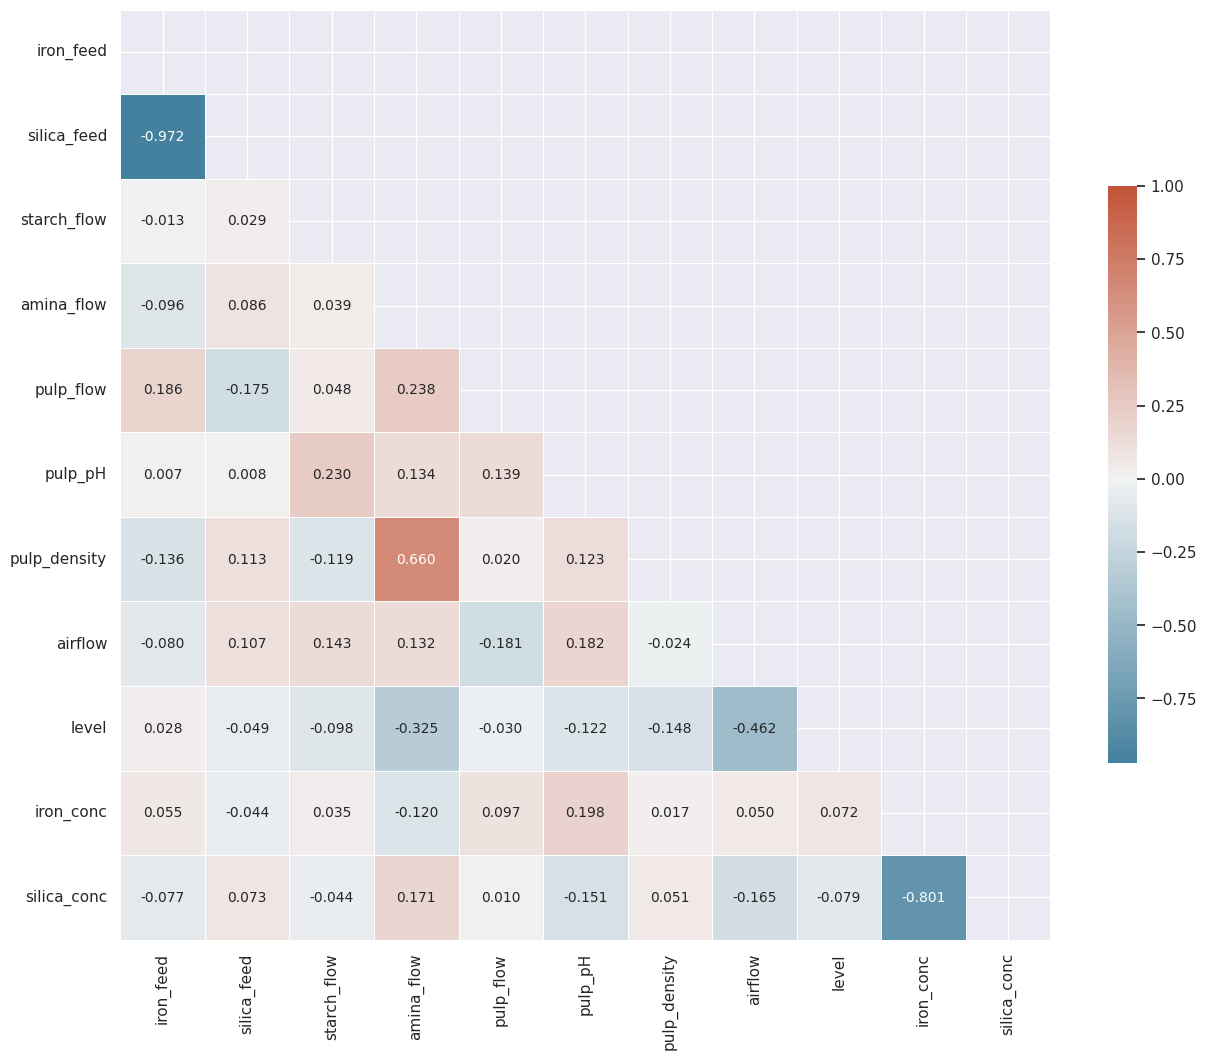

In [29]:
# Correlation Heatmap
f, ax = plt.subplots(figsize=(15, 15))
mat = flotation.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1,
            center=0, annot = True, square=True,
            linewidths=.5, annot_kws={"fontsize": 12},
            cbar_kws={"shrink": .5}, fmt='.3f')
plt.show()

**Correlation between the target variables (silica concentrate and iron concentrate) and features:**

- 'iron_feed' and 'silica_feed' have a strong negative correlation (-0.97), indicating that as the 'iron_feed' increases, 'silica_feed' decreases, and vice versa. This negative correlation suggests an inverse relationship between these variables.
- Target variables ('iron_conc' and 'silica_conc') also have a strong negative correlation (-0.80), indicating that as the 'iron_conc' increases, 'silica_conc' tends to decrease. This correlation suggests an inverse relationship between iron and silica concentrations.
- 'pulp_density' and 'amina_flow' have a moderate positive correlation (0.66), suggesting a tendency for these variables to increase or decrease together.
- 'pulp_pH' and 'level' have a moderate negative correlation (-0.46), indicating that as 'pulp_pH' increases, 'level' tends to decrease, and vice versa.
- 'pulp_pH' and 'airflow' have a moderate positive correlation (0.18), suggesting a tendency for these variables to increase or decrease together.

**Pairplot**

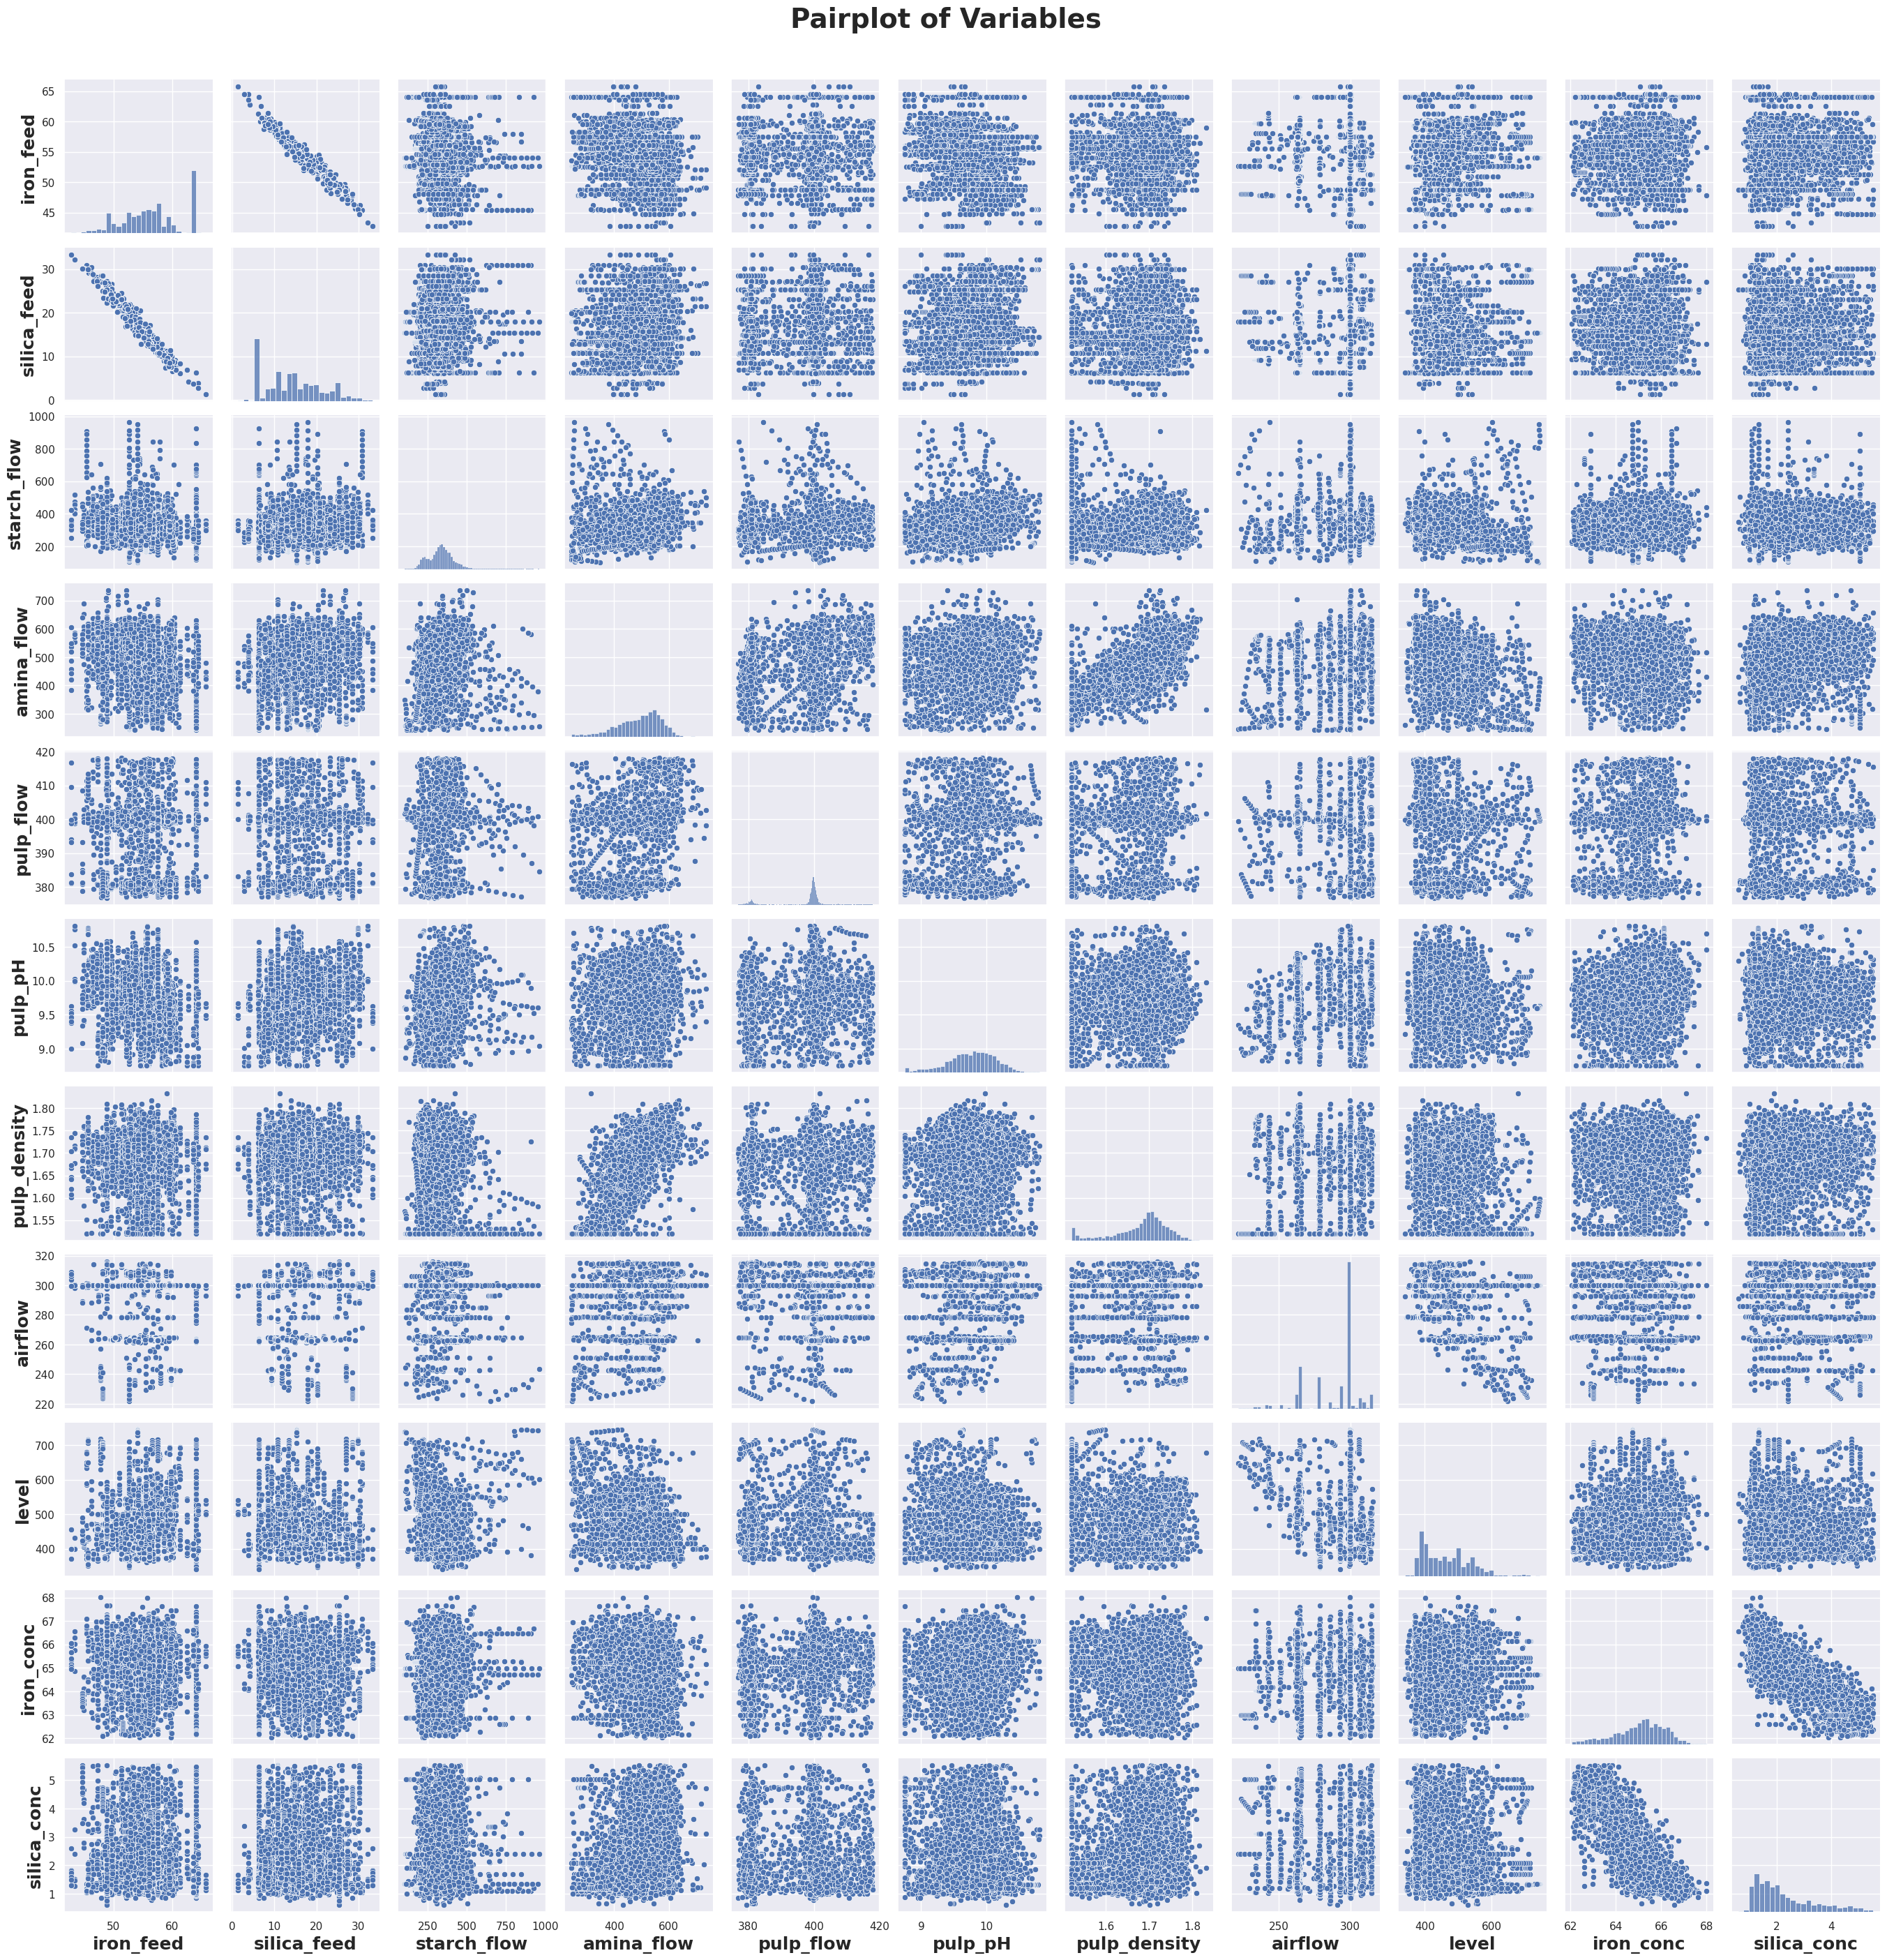

In [30]:
pairplot = sns.pairplot(flotation)
for ax in pairplot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=18, fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=18, fontweight='bold')

pairplot.fig.suptitle('Pairplot of Variables',
                      fontsize=28, fontweight='bold', y=1.025)
plt.show()

### **5.2. Relationships between target variable (Iron Concentrate) and Independent variables**

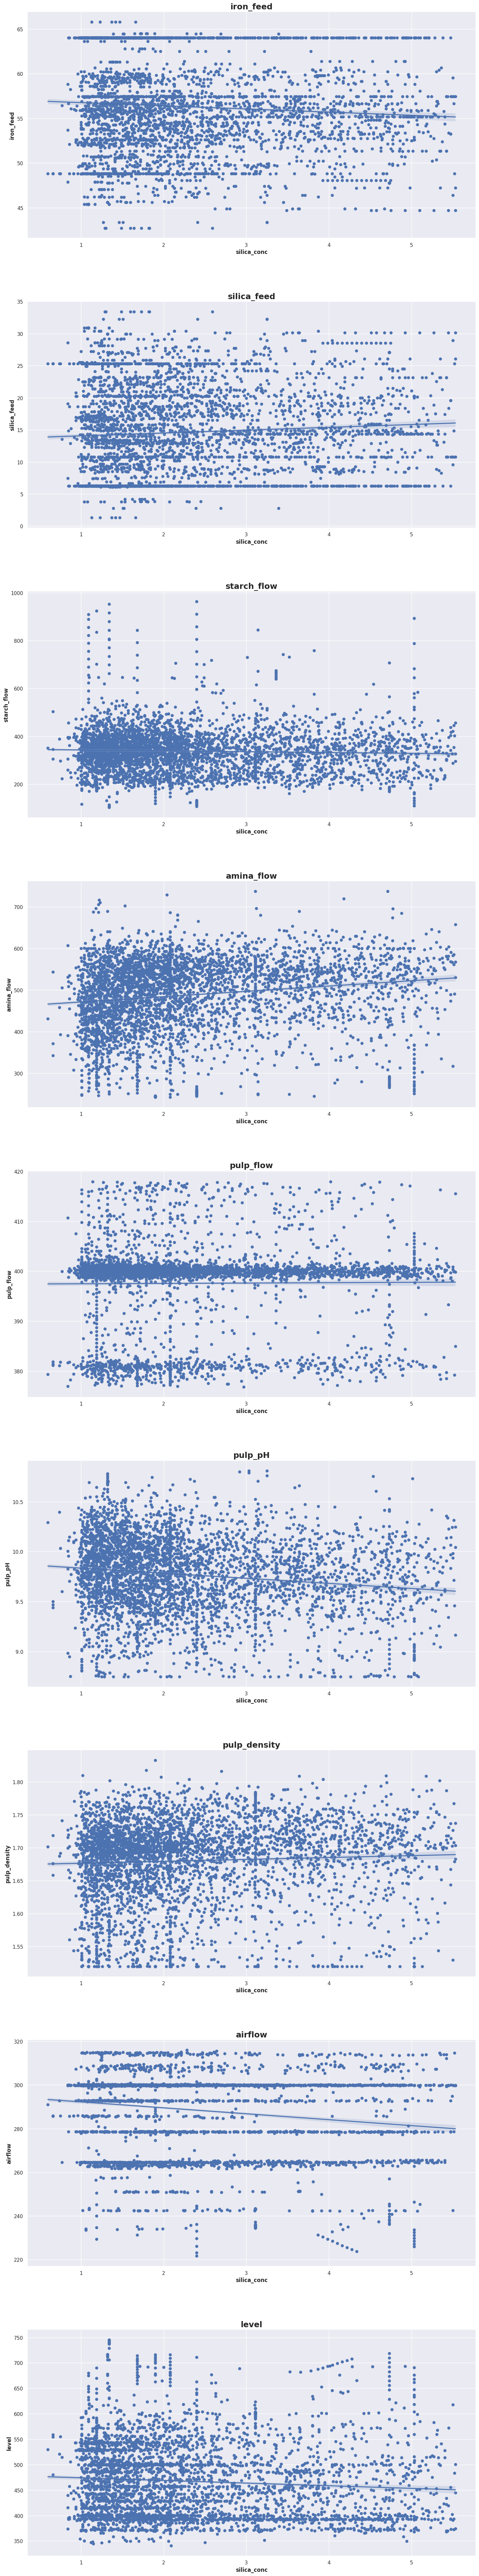

In [31]:
columns = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
           'pulp_flow', 'pulp_pH', 'pulp_density', 'airflow', 'level']

num_plots = min(len(columns), 9)
fig, axs = plt.subplots(9, 1, figsize=(15, 80))
axs = axs.flatten()

for i in range(num_plots):
    col = columns[i]
    sns.scatterplot(data=flotation, x='silica_conc', y=col, ax=axs[i])
    sns.regplot(data=flotation, x='silica_conc', y=col, ax=axs[i])
    axs[i].set_title(f'{col}', fontsize=18, fontweight='bold')
    axs[i].set_xlabel('silica_conc', fontsize=12, fontweight='bold')
    axs[i].set_ylabel(col, fontsize=12, fontweight='bold')

plt.tight_layout(h_pad=7)
plt.show()

- iron_feed shows an increase from 56% to 58%. However, the 4 fixed iron_feed values also attract attention.

- silica_feed, unlike iron_feed, has an average value of 16% to 14%. In addition, stability is observed for silica_feed at the values of 7%, 12%, 21%, 26%.

- The starch_flow graph shows a more concentrated distribution. It is seen that starch_flow values are collected in regions where iron_conc value is high.

- The amina_flow distribution shows a similar distribution to the starch_flow distribution. However, amina_flow values tend to decrease as iron_conc rises.

- In the pulp_flow graph, there is a concentration of 400 m3/h less intensely, around 380 m3/h, independent of the iron_conc value.

- The distribution in the pulp_pH graph is quite irregular and very scattered. When we look at the regplot line, an upward trend from 9.6 to 10 stands out.

- The distribution of pulp_density is very similar to pulp_pH. its average value follows a horizontal course around 1.68.

- air_flow is seen as having different fixed values independent of iron_conc.

- For the level variable, the concentration is between 350 mm and 550 mm.
- Generally, there are too much outliers in all scatterplots


### **5.3. P-values of Silica Concentrate vs Features**

In [32]:
target_variable = 'iron_conc'

# Filter the columns to exclude those that begin with the string "std"
filtered_columns = [col for col in flotation.columns if not col.startswith('std')]

# Create an empty DataFrame to store the results
p_value_df = pd.DataFrame(columns=['Variable', 'P-value'])

# Iterate over each variable in the filtered columns
for variable in filtered_columns:
    # Exclude the target variable itself
    if variable != target_variable:
        # Calculate the correlation coefficient and p-value between the target variable and the current variable
        correlation_coefficient, p_value = pearsonr(flotation[target_variable], flotation[variable])
        # Store the rounded p-value in the DataFrame
        p_value_df = p_value_df.append({'Variable': variable, 'P-value': round(p_value, 2)}, ignore_index=True)

sorted_p_values_df = p_value_df.sort_values(by='P-value', ascending=False)
sorted_p_values_df = sorted_p_values_df.reset_index(drop=True)
print("P values of Iron Concentrate vs Features")
print("")
sorted_p_values_df

P values of Iron Concentrate vs Features



Variable  P-value
0  pulp_density     0.28
1   starch_flow     0.02
2     iron_feed     0.00
3   silica_feed     0.00
4    amina_flow     0.00
5     pulp_flow     0.00
6       pulp_pH     0.00
7       airflow     0.00
8         level     0.00
9   silica_conc     0.00

- The variable 'pulp_density' has the highest p-value of 0.28, indicating a weak or insignificant correlation with 'iron_conc'.

- On the other hand, variables such as 'iron_feed', 'silica_feed', 'amina_flow', 'pulp_flow', 'pulp_pH', 'airflow', 'level', and 'silica_conc' have p-values of 0.00, suggesting a strong correlation with 'iron_conc'.

- The variable 'starch_flow' has a p-value of 0.02, which indicates a relatively moderate correlation with 'iron_conc'.

- These variables are likely to be more important in predicting the iron concentration.

### **5.4. Target Variable (Iron) Statistics**

**Histogram of Iron Concentrate**

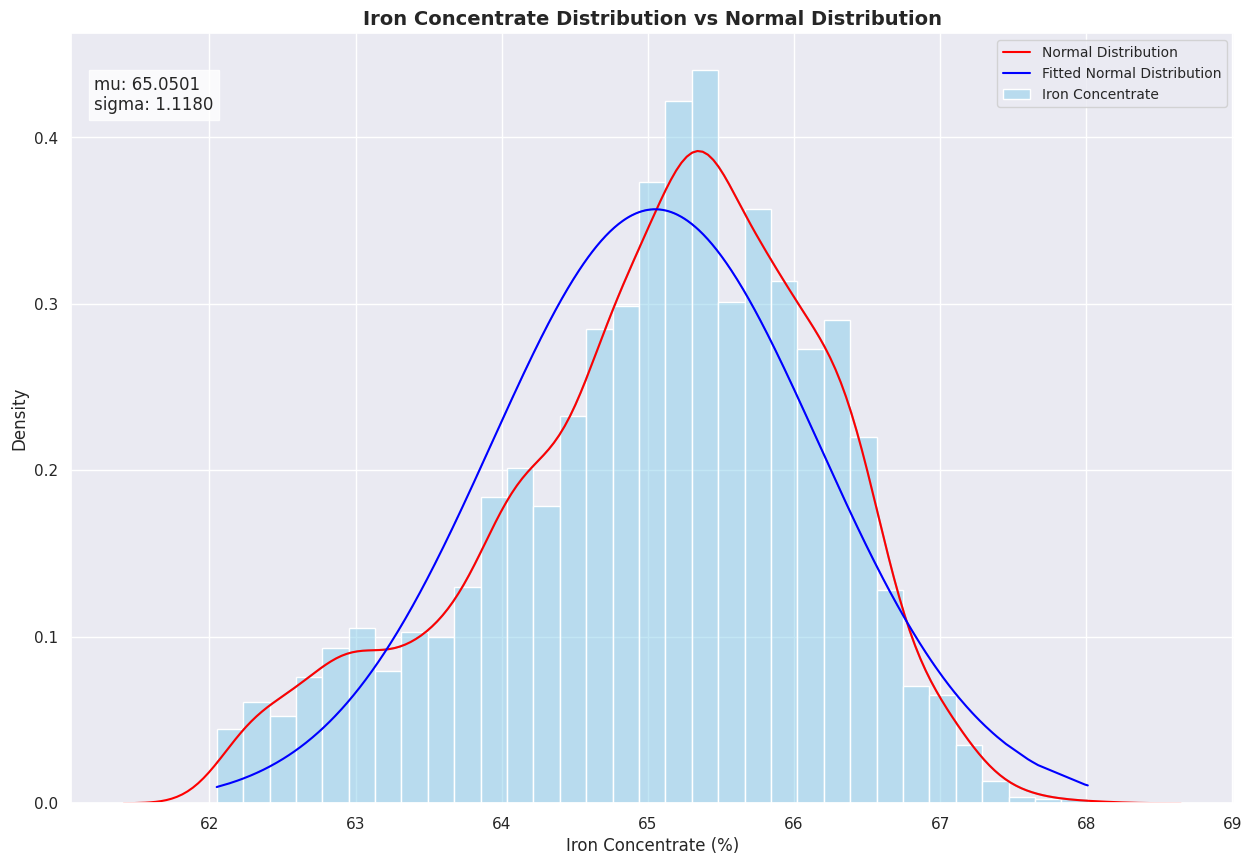

In [33]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['iron_conc'])

# Plotting the histogram, KDE, and fitted normal distribution
plt.figure(figsize=(15, 10))
sns.histplot(flotation['iron_conc'], kde=True, stat="density", common_norm=False,
color='skyblue', label='Iron Concentrate')
sns.kdeplot(flotation['iron_conc'], color='red', label='Normal Distribution')
sns.lineplot(x=flotation['iron_conc'], y=norm.pdf(flotation['iron_conc'], mu, sigma),
color='blue', label='Fitted Normal Distribution')

plt.text(0.02, 0.9, f"mu: {mu:.4f}\nsigma: {sigma:.4f}",
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

plt.title('Iron Concentrate Distribution vs Normal Distribution', fontsize=14, fontweight='bold')
plt.xlabel("Iron Concentrate (%)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.show()

- mu = 65.0501 indicates that, on average, the Iron Concentrate percentage is around 65.05%.
- sigma = The standard deviation of 1.1180 suggests that the data points are dispersed around the mean, with a typical deviation of approximately 1.11%.

- The histogram and KDE plot show the distribution of the actual data, while the red curve represents the fitted normal distribution.
- The blue line represents the line plot of the fitted normal distribution, providing a visual representation of how well the normal distribution fits the data.

**Skewness and Kurtosis**

In [34]:
t,p = stats.shapiro(flotation['iron_conc'])

print("Skewness: %f" % abs(flotation['iron_conc']).skew())
print("Kurtosis: %f" % abs(flotation['iron_conc']).kurt())
print("Shapiro_Test of t: %f" % t)
print("Shapiro_Test of p: %f" % p)

Skewness: -0.519475
Kurtosis: -0.195545
Shapiro_Test of t: 0.974148
Shapiro_Test of p: 0.000000


- The skewness is negative, it indicates that the distribution is slightly left-skewed, meaning that the tail of the distribution extends more towards lower values.

- The kurtosis is less than 0, it suggests that the distribution has lighter tails than a normal distribution, indicating it is slightly platykurtic.

- The Shapiro-Wilk test assesses the null hypothesis that the 'iron_conc' variable is normally distributed. In this case, the test statistic ('t') is 0.974150, and the p-value ('p') is 0.000000. Since the p-value is less than the significance level of 0.05, we can reject the null hypothesis. This suggests that the 'iron_conc' variable is not normally distributed.

- Overall, based on the skewness, kurtosis, and Shapiro-Wilk test results, the 'iron_conc' variable in the flotation dataset deviates slightly from a normal distribution. This implies that when working with this variable, it may be necessary to consider alternative statistical techniques or apply transformations to address the non-normality.

**Plotting the distribution of Iron Concentrate**

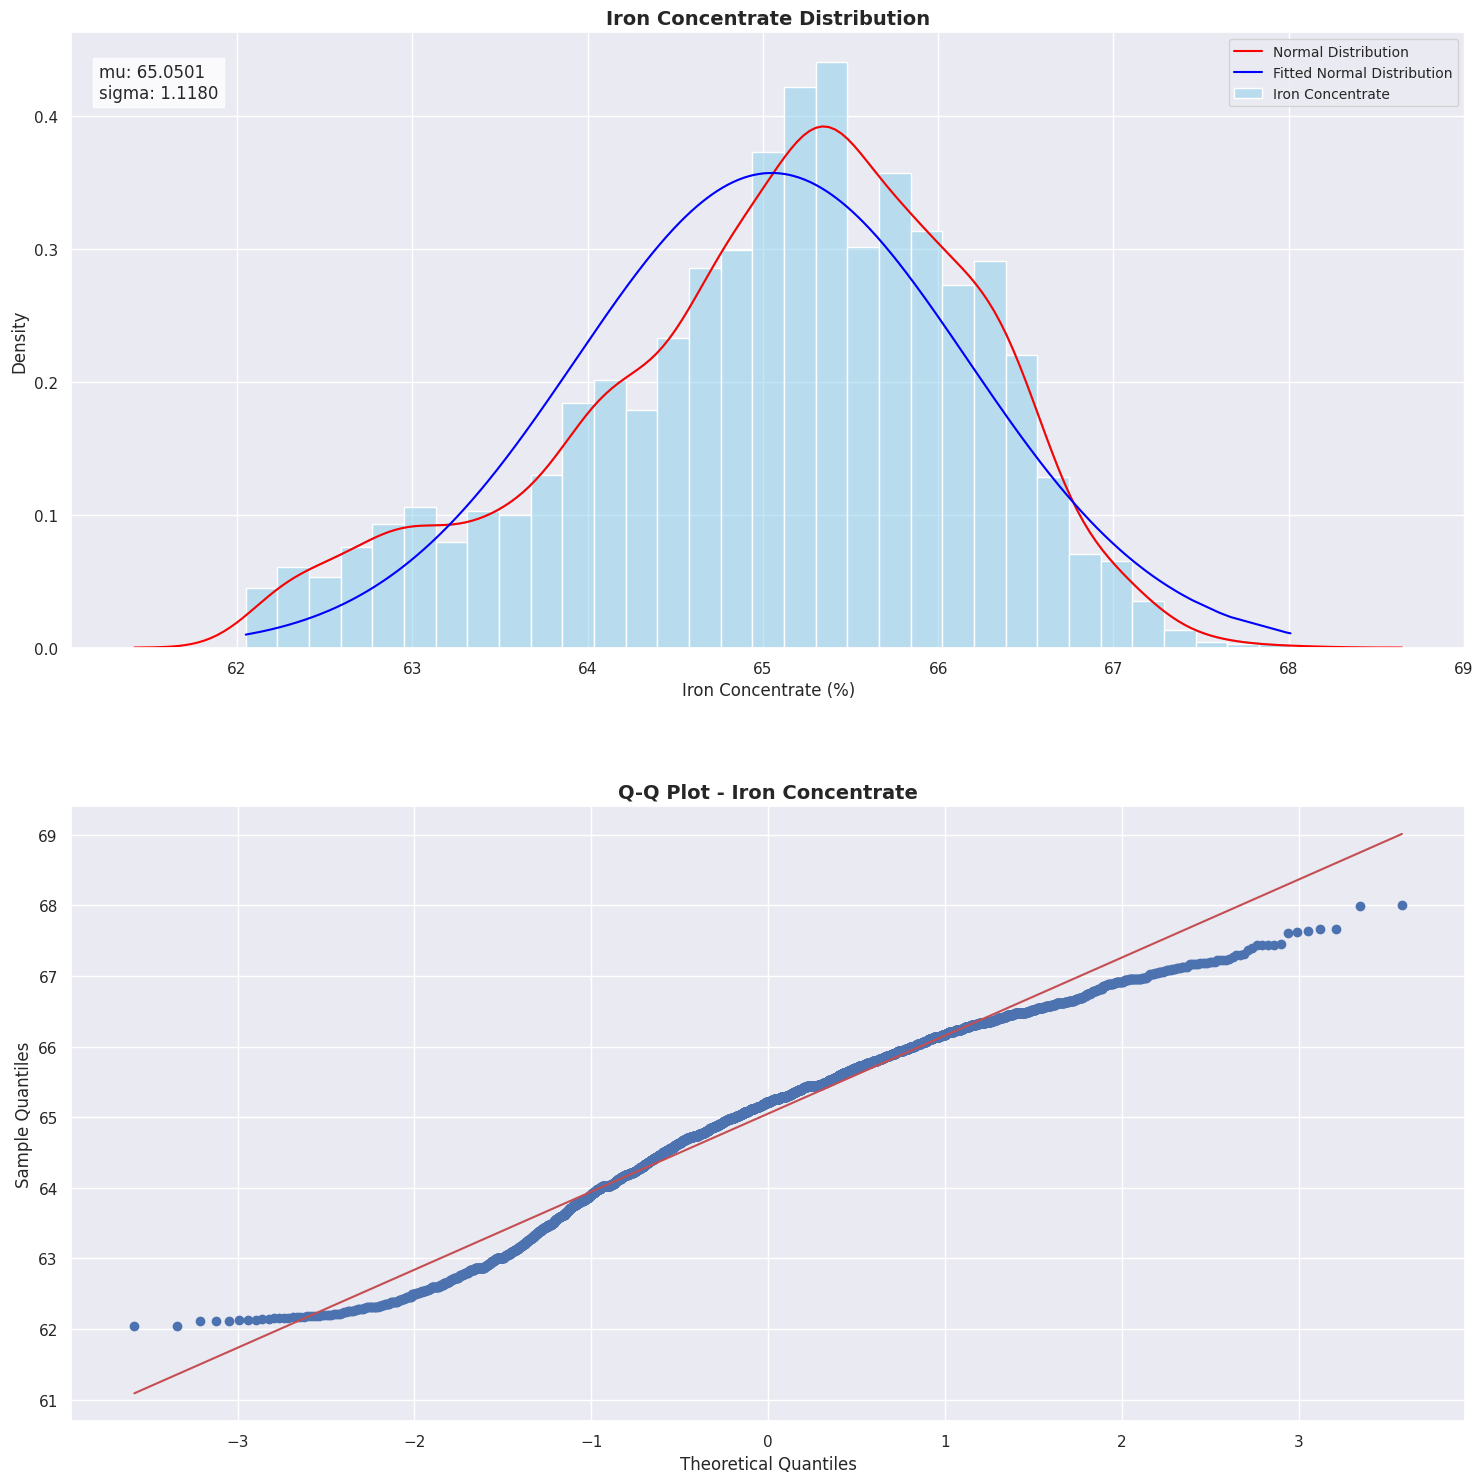

In [35]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['iron_conc'])

fig, axes = plt.subplots(2, 1, figsize=(15, 15))

# Histogram, KDE, and fitted normal distribution
sns.histplot(flotation['iron_conc'], kde=True, stat="density", common_norm=False,
             color='skyblue', label='Iron Concentrate', ax=axes[0])
sns.kdeplot(flotation['iron_conc'], color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=flotation['iron_conc'], y=norm.pdf(flotation['iron_conc'], mu, sigma),
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].text(0.02, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

axes[0].set_title('Iron Concentrate Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel("Iron Concentrate (%)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

# Q-Q plot
stats.probplot(flotation['iron_conc'], dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Iron Concentrate", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

- Tranform  silica concentration distribution into a normal one using log transformation.
- Plot qq-plot to see the transformation effect.

**Fitting the distribution of Iron Concentrate**

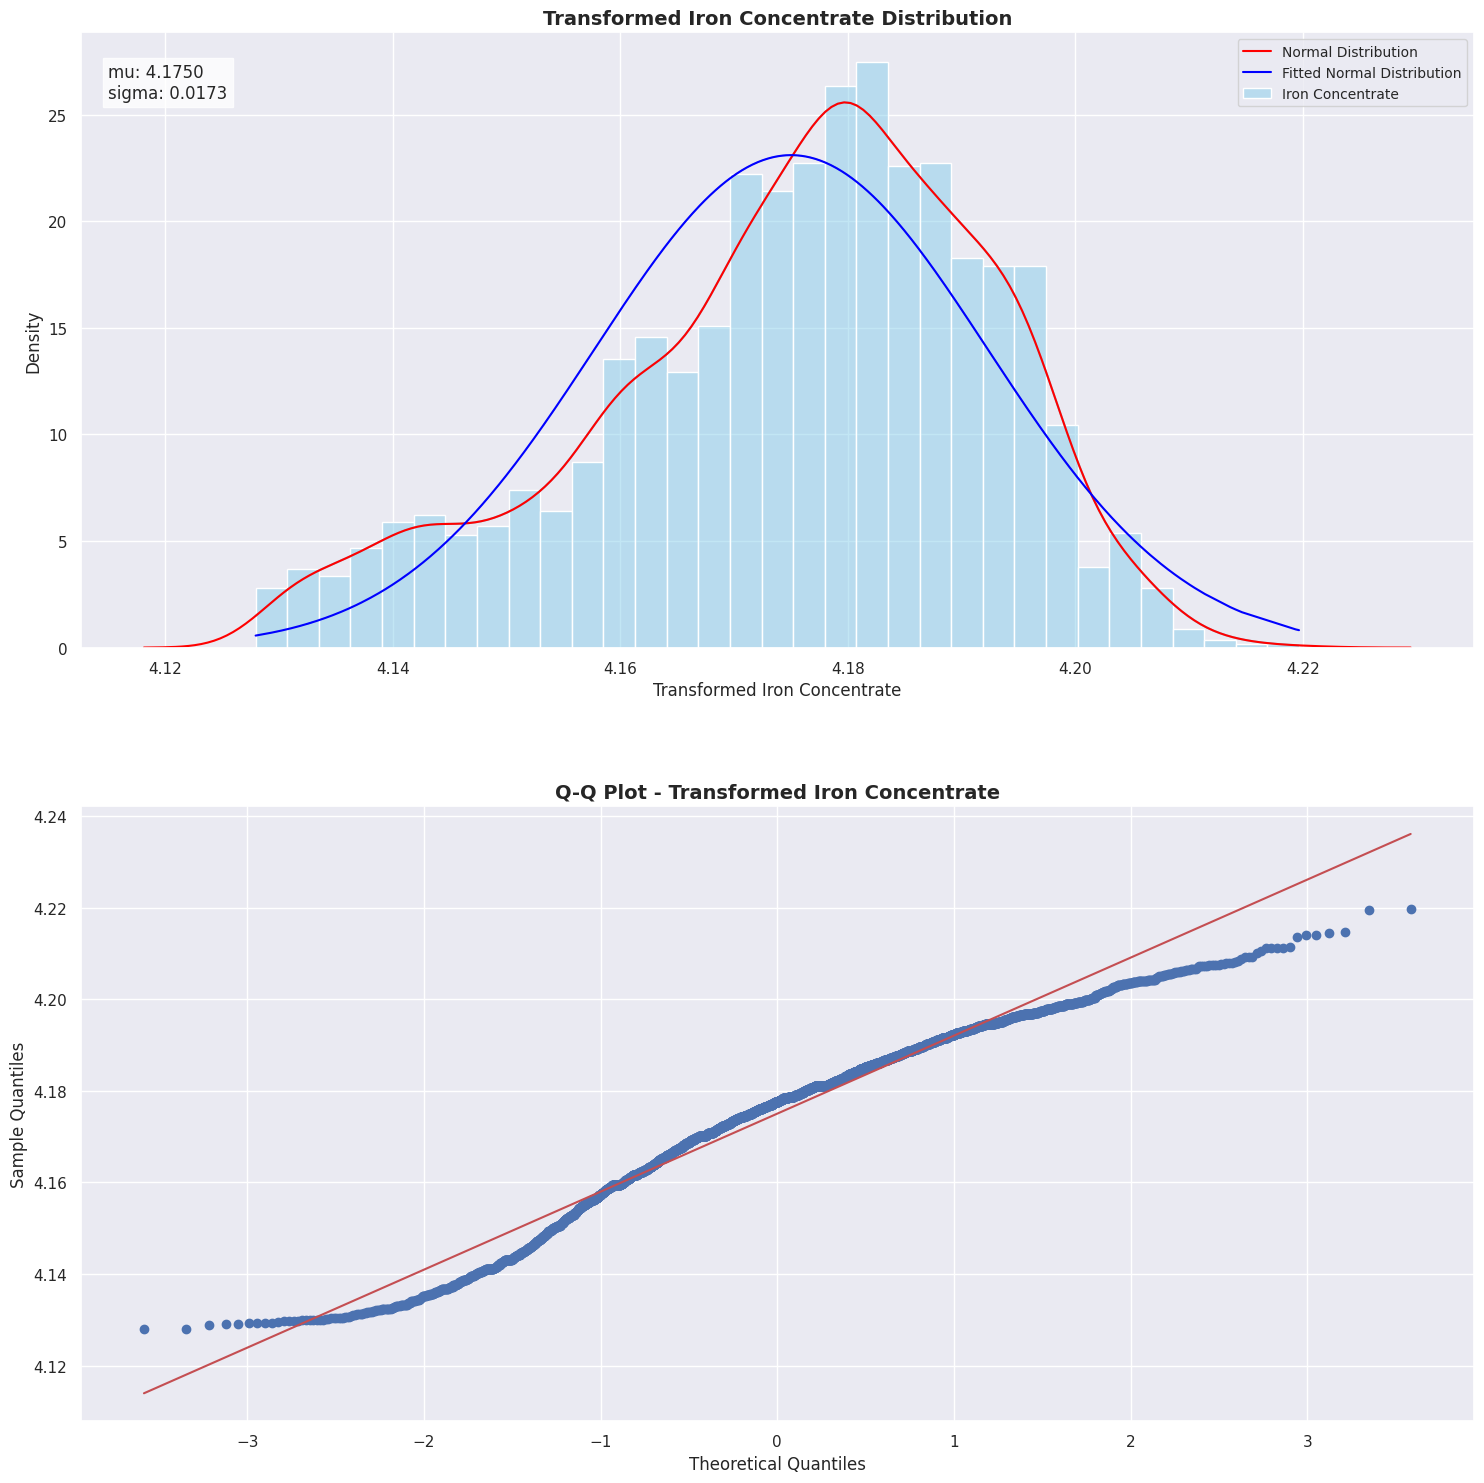

In [36]:
# Log transformation
transformed_conc = np.log(flotation['iron_conc'])

# Fitting normal distribution
(mu, sigma) = norm.fit(transformed_conc)

fig, axes = plt.subplots(2, 1, figsize=(15, 15))

sns.histplot(transformed_conc, kde=True, stat="density", common_norm=False,
             color='skyblue', label='Iron Concentrate', ax=axes[0])
sns.kdeplot(transformed_conc, color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=transformed_conc, y=norm.pdf(transformed_conc, mu, sigma),
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].set_title('Transformed Iron Concentrate Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel("Transformed Iron Concentrate", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

axes[0].text(0.02, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

# Q-Q plot for transformed data
stats.probplot(transformed_conc, dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Transformed Iron Concentrate", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

- **Histogram** shows the distribution of the transformed iron concentrate variable, with the density curve overlaid. The red curve represents a normal distribution fit to the data. The blue line represents the fitted normal distribution curve, which is based on the calculated mean (mu) of 4.1750 and standard deviation (sigma) of 0.0173.

- **Q-Q plot** compares the sample quantiles of the transformed iron concentrate data to the theoretical quantiles of a normal distribution. If the data points fall approximately along the diagonal line, it suggests that the data follows a normal distribution. In this case, the transformed iron concentrate data points align quite well with the diagonal line, indicating that the log-transformed variable approximates a normal distribution.

- According to the histogram, KDE plot, fitted normal distribution curve, and Q-Q plot, the log-transformed iron concentrate variable appears to exhibit a relatively normal distribution.


**Confidence Interval of Iron Concentrate**

Bootstrap Confidence Interval:
Lower Bound: 65.01569145445175
Upper Bound: 65.08436019580722


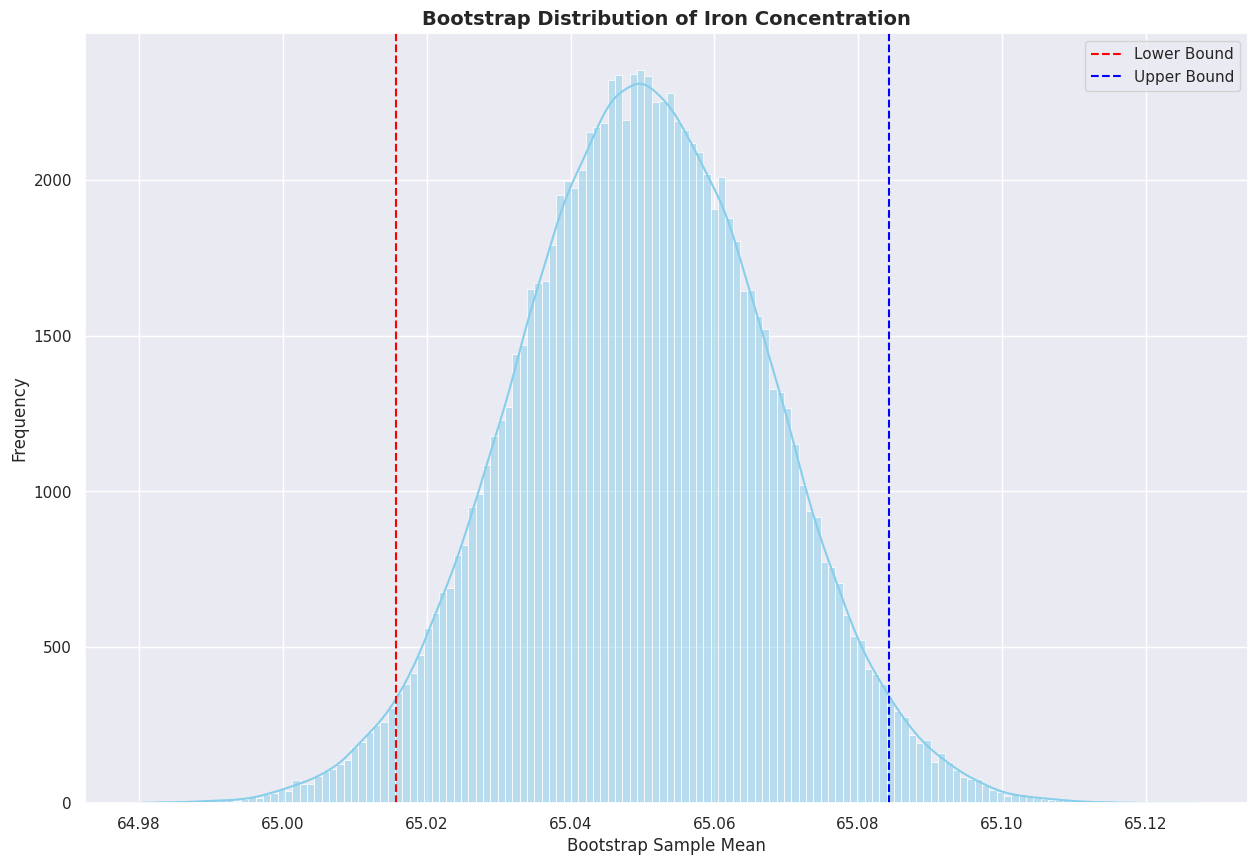

In [37]:
column_data = flotation["iron_conc"].values

num_iterations = 100000
confidence_level = 0.95

# Create an empty array to store the bootstrap sample means
bootstrap_means = np.empty(num_iterations)

# Perform the bootstrap sampling
for i in range(num_iterations):
    # Generate a bootstrap sample by sampling with replacement
    bootstrap_sample = np.random.choice(column_data,
                       size=len(column_data), replace=True)
    # Calculate the mean of the bootstrap sample
    bootstrap_means[i] = np.mean(bootstrap_sample)

# Sort the bootstrap means and calculate the lower and upper percentiles
sorted_means = np.sort(bootstrap_means)
lower_percentile = (1 - confidence_level) / 2
upper_percentile = 1 - lower_percentile

# Calculate the confidence interval
lower_bound = sorted_means[int(lower_percentile * num_iterations)]
upper_bound = sorted_means[int(upper_percentile * num_iterations)]

print("Bootstrap Confidence Interval:")
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Plot the bootstrap distribution
plt.figure(figsize=(15, 10))
sns.histplot(bootstrap_means, kde=True, color='skyblue')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='blue', linestyle='--', label='Upper Bound')
plt.xlabel('Bootstrap Sample Mean')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Iron Concentration',
          fontsize=14, fontweight='bold')
plt.legend()
plt.show()

The calculated bootstrap confidence interval for the "iron_conc" target variable is:

- Lower Bound: 65.01584056084398
- Upper Bound: 65.08429594825482

This means that we are 95% confident that the true population mean of the "iron_conc" column falls within this interval.

The bootstrap distribution plot shows the distribution of the bootstrap sample means, with the kernel density estimate (KDE) overlaid. The vertical red dashed lines represent the lower and upper bounds of the confidence interval.

Based on the histogram, we can see that the distribution of the bootstrap sample means is approximately symmetric and centered around a value close to 65.05.

- We can be 95% confident that the true mean iron concentration falls within the range of 65.0158 to 65.0843.

**Iron Concentrate vs Silica Concentrate**

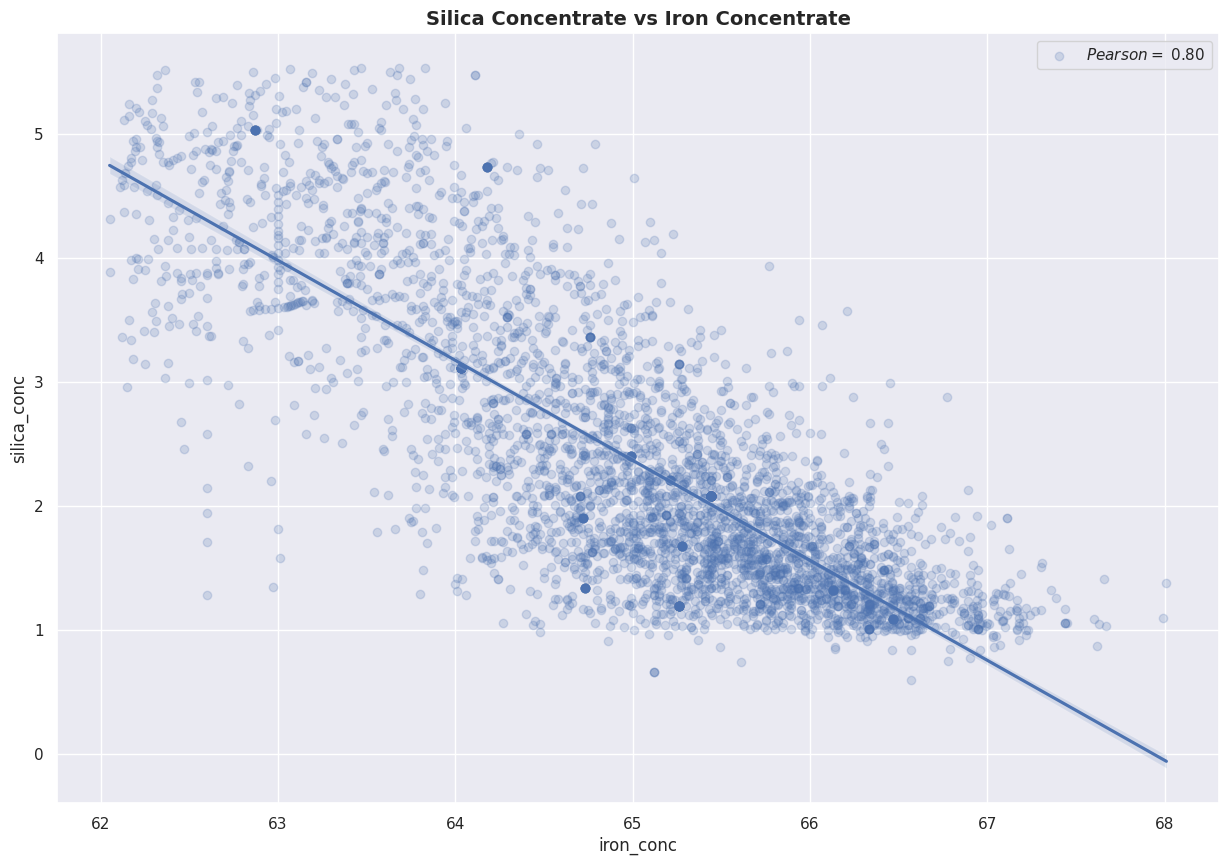

In [38]:
Pearson = 0.80
plt.figure(figsize = (15,10))
sns.regplot(data=flotation, x = 'iron_conc', y='silica_conc', scatter_kws={'alpha':0.2})
plt.title('Silica Concentrate vs Iron Concentrate', fontsize = 14, fontweight='bold')
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson)], loc = 'best')
plt.show()

Scatter plot shows the relationship between Silica Concentrate and Iron Concentrate in the flotation dataset. The Pearson correlation coefficient of -0.80 indicates a strong negative linear correlation between Silica Concentrate and Iron Concentrate in the flotation dataset.

In this case, as the Silica Concentrate decreases, there is a tendency for the Iron Concentrate to increases. This negative correlation suggests that higher levels of Silica Concentrate in the flotation process are associated with lower levels of Iron Concentrate.

While there may be some outliers in the data, the majority of the data points follow the negative correlation trend. This information is valuable in the context of the flotation process as it helps identify the inverse relationship between Silica Concentrate and Iron Concentrate.

Understanding this negative correlation is important for process optimization. It allows for monitoring and controlling Silica Concentrate levels to minimize their impact on Iron Concentrate production. By managing and reducing Silica Concentrate levels, it may be possible to improve the overall quality and yield of Iron Concentrate.

Scatter plot and the strong negative correlation between Silica Concentrate and Iron Concentrate emphasize the need to effectively control Silica Concentrate levels to enhance the production of Iron Concentrate in the flotation process.

## **6. Modelling**

### **6.1. Splitting Dataset**

**Split Dataset as X and y**

In [39]:
X = flotation.drop(['silica_conc', 'iron_conc'], axis=1)
y_Fe = flotation['iron_conc']

print("Shape of X:", X.shape)
print("Shape of y_Fe:", y_Fe.shape)

Shape of X: (4097, 9)
Shape of y_Fe: (4097,)


**Split (train, validation, test)**

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Fe, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (3277, 9)
Shape of X_val: (410, 9)
Shape of X_test: (410, 9)


### **6.2. MSE - MAE - R^2**

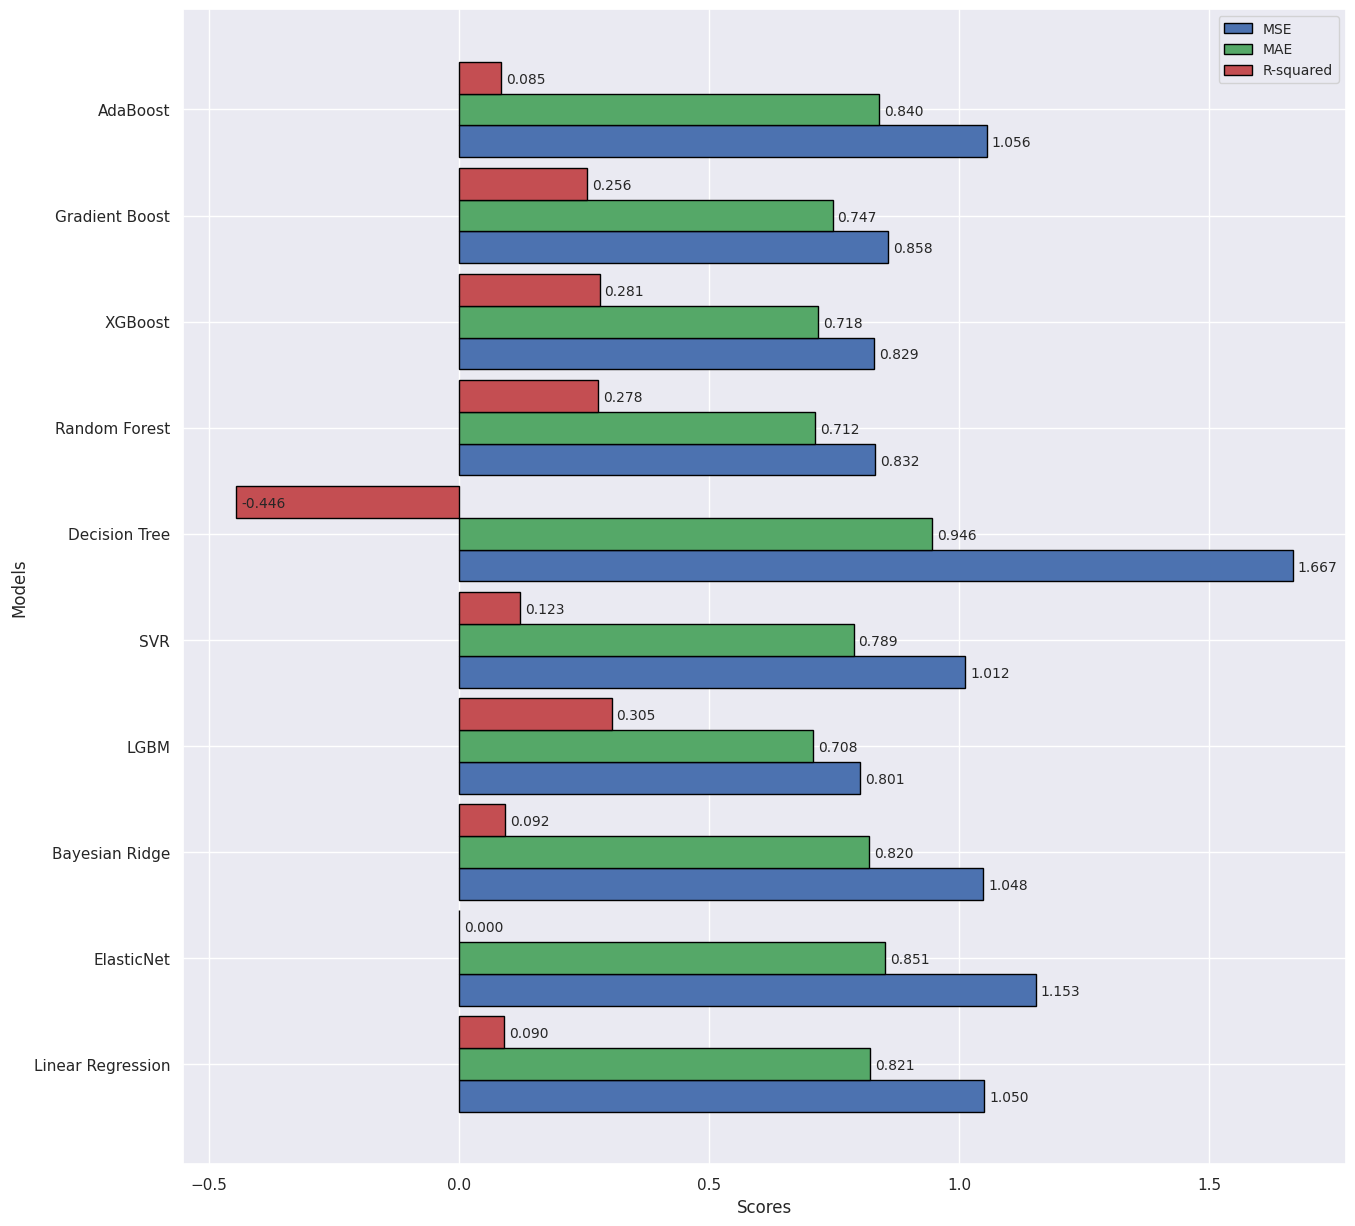

Model       MSE       MAE       R^2  Training Time  \
0               LGBM  0.801373  0.707661  0.305233       0.227785   
1            XGBoost  0.829221  0.717999  0.281090       3.334084   
2      Random Forest  0.832260  0.712428  0.278455       2.604049   
3     Gradient Boost  0.857745  0.746971  0.256361       1.023531   
4                SVR  1.011724  0.789060  0.122865       0.542923   
5     Bayesian Ridge  1.047698  0.820305  0.091677       0.026958   
6  Linear Regression  1.050080  0.821365  0.089612       0.039398   
7           AdaBoost  1.055576  0.840059  0.084847       0.156274   
8         ElasticNet  1.153373  0.851374  0.000060       0.021337   
9      Decision Tree  1.667458  0.946299 -0.445636       0.050083   

   Prediction Time  
0         0.004476  
1         0.005110  
2         0.029479  
3         0.005147  
4         0.081410  
5         0.002258  
6         0.002489  
7         0.003841  
8         0.002433  
9         0.001936

In [41]:
# Define the models and their corresponding names
models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]

mse_scores = []
mae_scores = []
r2_scores = []
train_times = []
predict_times = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', model)])

    # Measure training time
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Measure prediction time
    start_time = time.time()
    val_pred = pipeline.predict(X_val)
    predict_time = time.time() - start_time

    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)

    # Append the scores and times to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    train_times.append(train_time)
    predict_times.append(predict_time)

# Plot evaluation metrics
bar_width = 0.3
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(15, 15))
plt.barh(r1, mse_scores, color='b', height=bar_width, edgecolor='black', label='MSE')
plt.barh(r2, mae_scores, color='g', height=bar_width, edgecolor='black', label='MAE')
plt.barh(r3, r2_scores, color='r', height=bar_width, edgecolor='black', label='R-squared')
plt.ylabel('Models', fontsize=12)
plt.xlabel('Scores', fontsize=12)
plt.yticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='upper right', fontsize=10)

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(mse + 0.01, i - 0.05, f'{mse:.3f}', fontsize=10)
    plt.text(mae + 0.01, i + bar_width - 0.05, f'{mae:.3f}', fontsize=10)
    plt.text(r2 + 0.01, i + 2 * bar_width - 0.05, f'{r2:.3f}', fontsize=10)

plt.show()

# Write the evaluation metric scores and execution times
scores_df = pd.DataFrame({'Model': [model_name for _, model_name in models],
                          'MSE': mse_scores,
                          'MAE': mae_scores,
                          'R^2': r2_scores,
                          'Training Time': train_times,
                          'Prediction Time': predict_times})

scores_df = scores_df.sort_values(by='MSE', ascending=True)
scores_df = scores_df.reset_index(drop=True)
scores_df

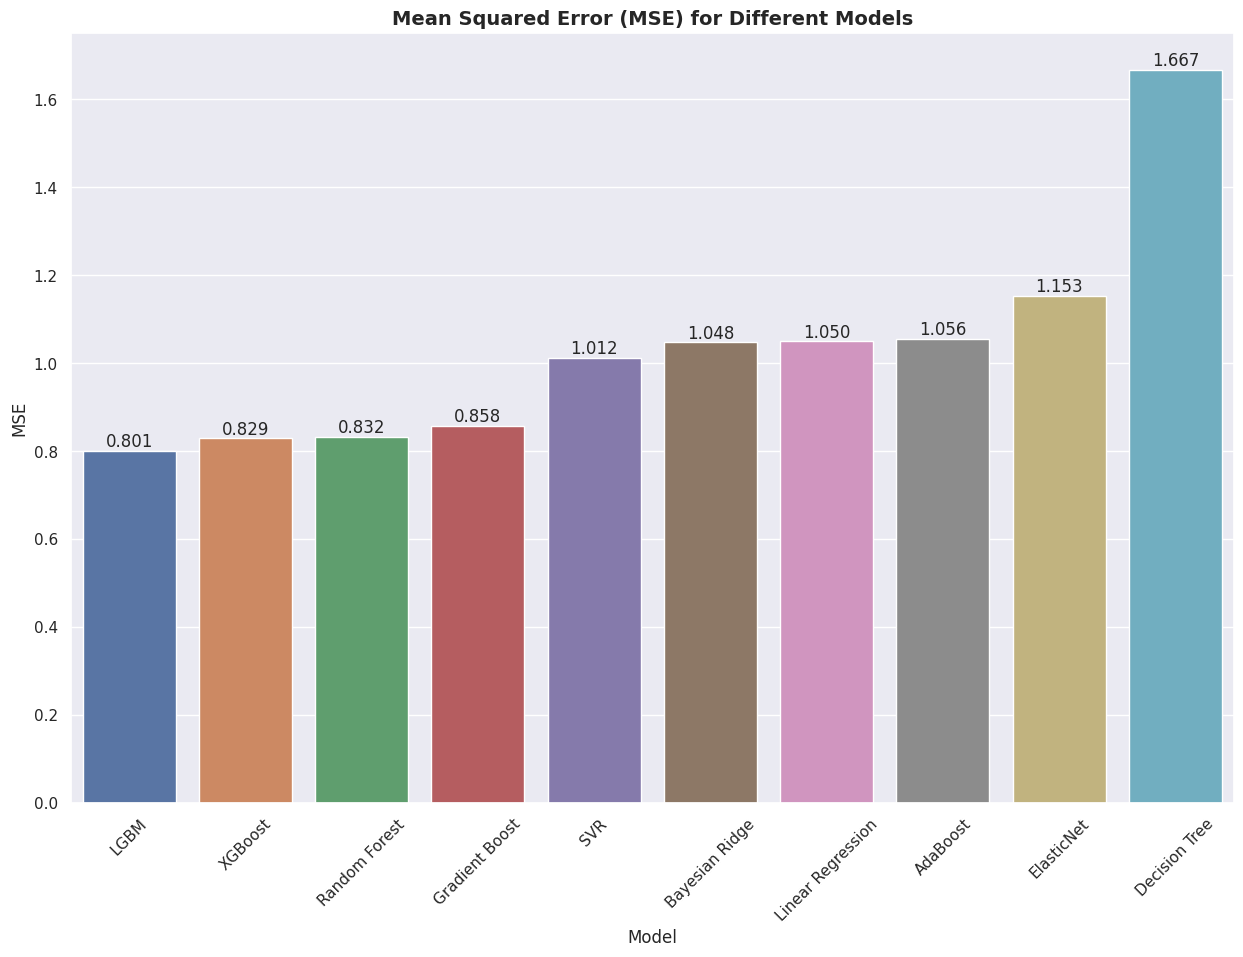

In [42]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Model', y='MSE', data=scores_df)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(rotation=45)
plt.title('Mean Squared Error (MSE) for Different Models', fontsize = 14, fontweight='bold')

for i, row in scores_df.iterrows():
    plt.text(i, row['MSE'], f'{row["MSE"]:.3f}', ha='center', va='bottom')

plt.show()

Among the models evaluated, LGBM and Random Forest perform the best with the lowest mean squared error (MSE) and mean absolute error (MAE), indicating higher accuracy in prediction. They also have the highest R^2 value, suggesting that it explains a significant portion of the variance in the data. XGBoost follows with slightly higher MSE, MAE, and slightly lower R^2 compared to Random Forest.

On the other hand, Gradient Boost, SVR, Bayesian Ridge, Linear Regression, AdaBoost, ElasticNet, and Decision Tree perform worse than the top models. They have higher MSE and MAE values, indicating less accurate predictions, and lower R^2 values, indicating a weaker ability to explain the variance in the data. Decision Tree performs the worst among all the models, with the highest MSE, MAE, and a significantly negative R^2 value.

Overall, Random Forest, LGBM, and XGBoost show better performance, while the remaining models struggle to accurately capture the patterns in the data and explain its variance.

### **6.3. Cross validation**

**10 Fold Cross validation**

In [43]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Define the models and their corresponding names
models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (xgb.XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]

cv_scores = []
cv_std = []
execution_times = []

# Perform cross-validation for each model
for model, model_name in models:
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train,
                             scoring='neg_root_mean_squared_error', cv=kf)
    end_time = time.time()
    execution_time = end_time - start_time

    cv_scores.append(-scores.mean())
    cv_std.append(scores.std())
    execution_times.append(execution_time)

# Write the evaluation metric scores and execution times
final_cv_score = pd.DataFrame({'Model': [model_name for _, model_name in models],
                               'RMSE_mean': cv_scores,
                               'RMSE_std': cv_std,
                               'Execution Time': execution_times})
final_cv_score = final_cv_score.sort_values(by='RMSE_mean', ascending=True)
final_cv_score = final_cv_score.reset_index(drop=True)
final_cv_score

Model  RMSE_mean  RMSE_std  Execution Time
0               LGBM   0.931161  0.034564        1.399525
1      Random Forest   0.945189  0.035988       25.029943
2            XGBoost   0.961907  0.044351        8.462057
3     Gradient Boost   0.987489  0.030503        9.500855
4  Linear Regression   1.057838  0.034940        0.084636
5     Bayesian Ridge   1.058058  0.034704        0.137839
6           AdaBoost   1.072358  0.027150        2.861290
7         ElasticNet   1.096110  0.030343        0.073270
8                SVR   1.097486  0.029160        4.764755
9      Decision Tree   1.320273  0.076141        0.359375

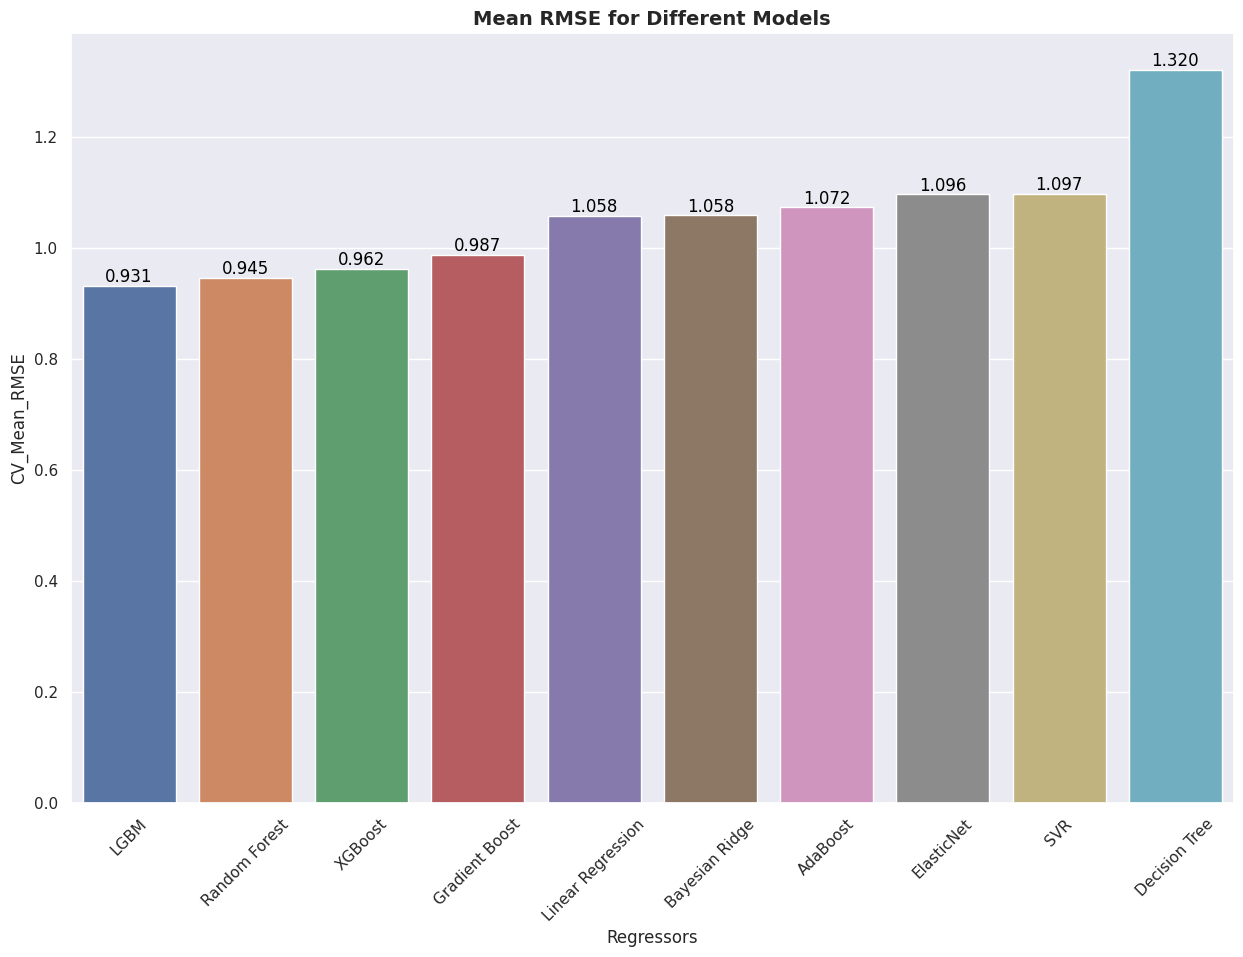

In [44]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Model', y='RMSE_mean', data=final_cv_score)
plt.xlabel('Regressors', fontsize=12)
plt.ylabel('CV_Mean_RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.title('Mean RMSE for Different Models', fontsize = 14, fontweight='bold')

for i, row in final_cv_score.iterrows():
    plt.text(i, row['RMSE_mean'], f'{row["RMSE_mean"]:.3f}', color='black', ha='center', va='bottom')

plt.show()

Among the models, LGBM, Random Forest, and XGBoost demonstrate the best performance with the lowest RMSE means. These models consistently produce accurate predictions, as indicated by their relatively low standard deviations.

Gradient Boost performs slightly worse than the top models, but still shows a relatively low standard deviation, indicating consistent performance.

Linear Regression and Bayesian Ridge have similar RMSE means and standard deviations, performing slightly worse than Gradient Boost.

AdaBoost also performs reasonably well with a slightly higher RMSE mean but a lower standard deviation, suggesting consistent performance.

ElasticNet and SVR exhibit higher RMSE means and standard deviations, indicating less accurate predictions and more variability in performance.

Decision Tree performs the worst among all the models, with the highest RMSE mean and a higher standard deviation, indicating less accurate and more inconsistent predictions.

Finally, LGBM, Random Forest, and XGBoost demonstrate the best performance, while Decision Tree shows the poorest performance among the evaluated models.

### **6.4. Hyperparameter Optimization**

**Perform Grid Search for RandomForestRegressor and LGBMRegressor**

In [45]:
# Define the model
model = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Perform Grid Search
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_search_time = end_time - start_time

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time

# Evaluate the best model on the validation data
start_time = time.time()
val_pred = best_model.predict(X_val)
end_time = time.time()
prediction_time = end_time - start_time

# Calculate evaluation metrics
mse = mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

# Print the results
print(f"Best Hyperparameters: {best_params}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Grid Search Time: {grid_search_time:.3f} seconds")
print(f"Fit Time: {fit_time:.3f} seconds")
print(f"Prediction Time: {prediction_time:.3f} seconds")

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 0.819
MAE: 0.711
R^2: 0.290
Grid Search Time: 426.041 seconds
Fit Time: 5.119 seconds
Prediction Time: 0.049 seconds


In [46]:
# Define the model
model = LGBMRegressor(objective='regression')

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10]}

# Perform Grid Search
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_search_time = end_time - start_time

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time

# Evaluate the best model on the validation data
start_time = time.time()
val_pred = best_model.predict(X_val)
end_time = time.time()
prediction_time = end_time - start_time

# Calculate evaluation metrics
mse = mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

# Print the results
print(f"Best Hyperparameters: {best_params}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Grid Search Time: {grid_search_time:.3f} seconds")
print(f"Fit Time: {fit_time:.3f} seconds")
print(f"Prediction Time: {prediction_time:.3f} seconds")

Best Hyperparameters: {'max_depth': None, 'n_estimators': 100}
MSE: 0.786
MAE: 0.698
R^2: 0.319
Grid Search Time: 12.196 seconds
Fit Time: 0.121 seconds
Prediction Time: 0.004 seconds


LGBMRegressor performed slightly better than RandomForestRegressor based on the evaluation metrics. It achieved lower MSE and MAE, indicating better accuracy, and a slightly higher R^2, suggesting a better fit to the data. Additionally, LGBMRegressor required significantly less time for grid search, fitting, and prediction processes.

Considering these factors,  LGBMRegressor seems to be a favorable choice in terms of performance and computational efficiency. However, further analysis and experimentation may be necessary to confirm the model's suitability and ensure its robustness for the specific problem domain.

### **6.5. Model interpretation**

**Feature importance**

Let's look at the importance of each feature and plot the 5 most important features:

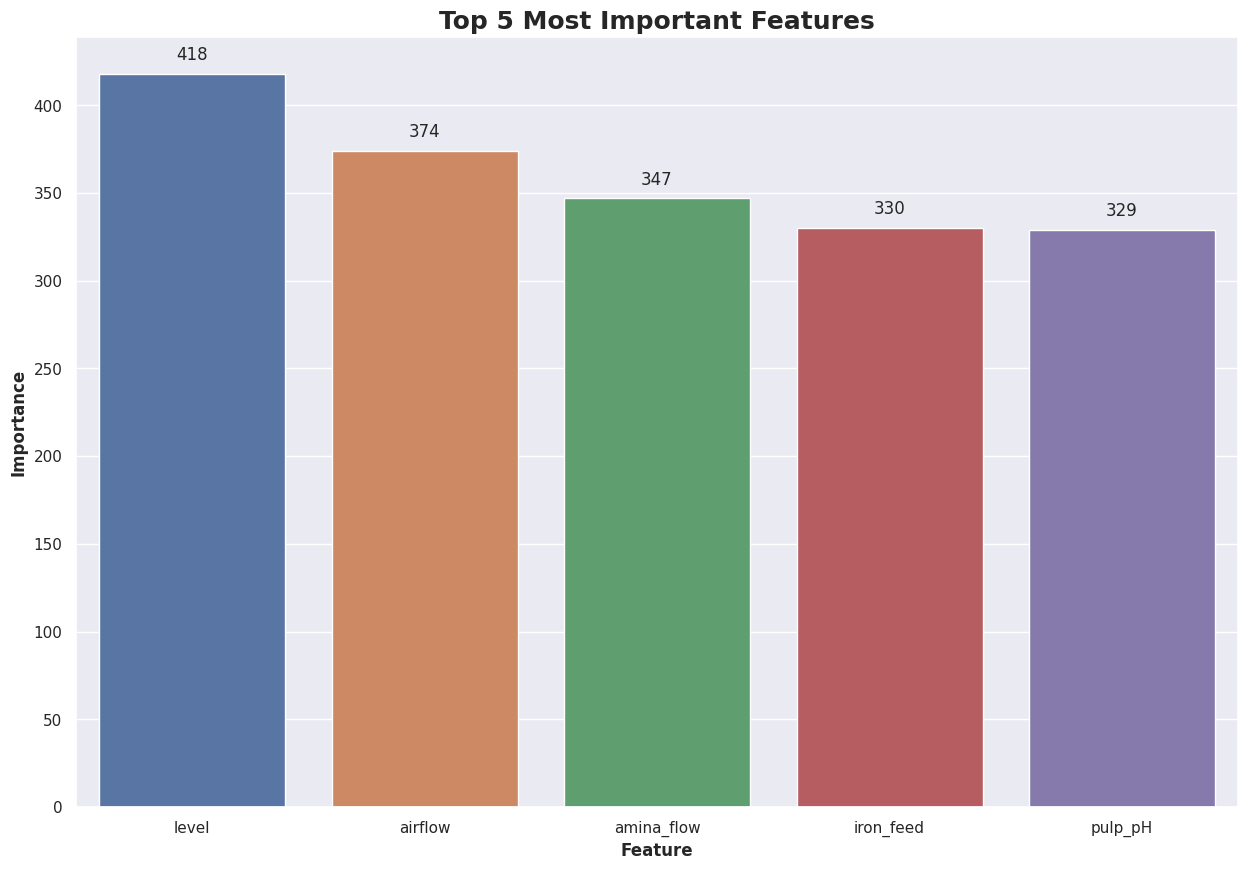

In [47]:
importances = best_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 10))
ax = sns.barplot(data=feature_importances.head(5), x='Feature', y='Importance')
plt.title('Top 5 Most Important Features', fontsize=18, fontweight='bold')
plt.xlabel('Feature', fontsize=12, fontweight='bold')
plt.ylabel('Importance', fontsize=12, fontweight='bold')

# Annotate the feature importance values on the bars
for i, importance in enumerate(feature_importances.head(5)['Importance']):
    ax.annotate(round(importance, 2), (i, importance),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=12)

plt.show()

The top 5 most important features, as determined by the LGBMRegressor model:

1. Level: This feature has the highest importance score, indicating that it has the most significant impact on the target variable. The level of a certain parameter in the flotation process seems to have a strong correlation with the outcome.

2. Airflow: The airflow in the flotation process is the second most important feature. It suggests that controlling and optimizing the airflow can have a significant effect on the desired outcome.

3. Amina Flow: The flow rate of amina, a chemical reagent used in the flotation process, is another important feature. This indicates that the amount of amina being introduced plays a crucial role in achieving the desired results.

4. Iron Feed: The iron feed, which represents the concentration of iron in the feed, is a significant factor in determining the outcome of the flotation process. This suggests that the initial iron concentration has a strong influence on the final result.

5. Pulp pH: The pH level of the pulp, which is the mixture of water and ore particles in the flotation process, is also an important feature. Maintaining the appropriate pH level is essential for optimal flotation performance.

These findings provide insights into the factors that have the most influence on the flotation process. Understanding the importance of these features can help guide process optimization and decision-making to improve the desired outcome.

**Identifiying redundant features**

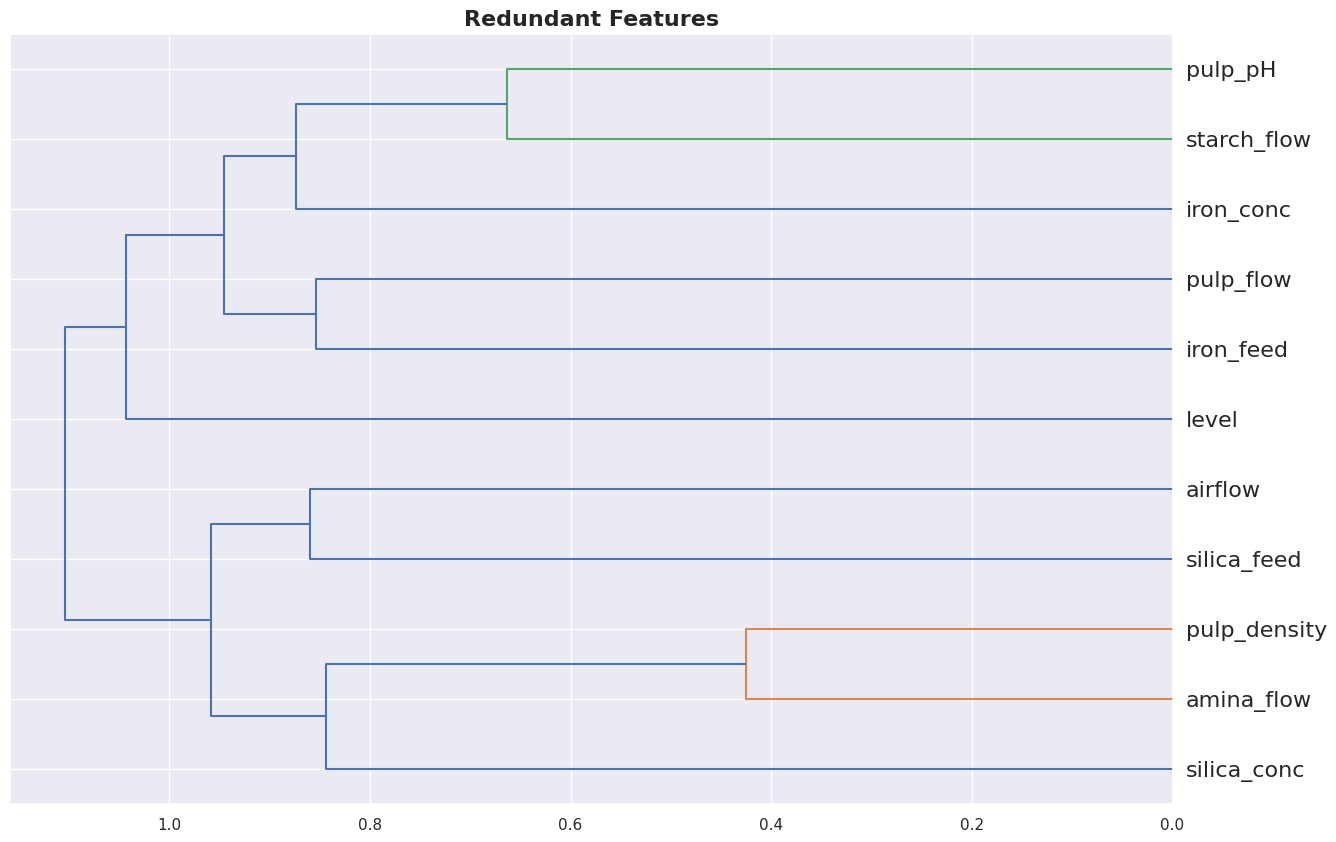

In [48]:
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(flotation).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(15,10))
dendrogram = hc.dendrogram(z, labels=flotation.columns, orientation='left', leaf_font_size=16)
plt.title('Redundant Features', fontsize=16, fontweight='bold')
plt.show()



The hierarchical clustering results indicate the relationship and similarity between the features. The clusters formed are as follows:

- Cluster 1: ['silica_conc', 'amina_flow', 'pulp_density']
- Cluster 2: ['silica_feed', 'airflow', 'level']
- Cluster 3: ['iron_feed', 'pulp_flow']
- Cluster 4: ['iron_conc', 'starch_flow', 'pulp_pH']

The order of the features after hierarchical clustering is:

1. 'silica_conc'
2. 'amina_flow'
3. 'pulp_density'
4. 'silica_feed'
5. 'airflow'
6. 'level'
7. 'iron_feed'
8. 'pulp_flow'
9. 'iron_conc'
10. 'starch_flow'
11. 'pulp_pH'


Hierarchical clustering shows how each feature correlates with the others. The features which merge on the right hand side are closer to each other, suggesting that potentially only one of both would be sufficient for training the model. This could be useful to reduce the colinearity of different features.

## **7. Conclussion**

The dataset consists of various features related to the flotation process, with the target variable being the Iron Concentrate.

Exploratory data analysis revealed some important insights, such as the distribution of the Iron Concentrate values, skewness, and kurtosis.

Several regression models were trained and evaluated on the dataset. The models included Linear Regression, ElasticNet, Bayesian Ridge, LGBM, SVR, Decision Tree, Random Forest, XGBoost, Gradient Boost, and AdaBoost. Evaluation metrics such as MSE, MAE, and R^2 were used to assess the models' performance.

Random Forest and LGBM models achieved the best results among the tested models. Both models were further tuned using grid search and cross-validation. The best-performing model was selected based on the lowest MSE, and the selected model was evaluated on the validation dataset.

The LGBM model, with the selected hyperparameters, demonstrated the best performance in terms of MSE, MAE, and R^2. It outperformed other models, including Random Forest. Therefore, **LGBM model is recommended for predicting the Iron Concentrate in future scenarios.**

In addition to the model evaluation, feature importance was also analyzed to understand the significant variables that contribute to predicting the Iron Concentrate.

The top 5 most important features identified by the LGBM model were 'level', 'airflow', 'amina_flow', 'iron_feed', and 'pulp_pH'. These features had the highest impact on predicting the Iron Concentrate.

The feature importance analysis provides insights into the underlying relationships between the features and the target variable. Understanding the importance of different features can help in focusing on key variables during process optimization and decision-making.

Overall, the combination of model evaluation and feature importance analysis suggests that the 'level', 'airflow', 'amina_flow', 'iron_feed', and 'pulp_pH' features play a crucial role in predicting the Iron Concentrate in the flotation process. These insights can be valuable for process engineers and operators to optimize the flotation process and improve the quality of the Iron Concentrate output.
